# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np
from os import listdir
%config Completer.use_jedi = False

with open("functions/physio_def_0.py") as f:
    exec(f.read())

In [2]:
from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))

from general_functions import tally

In [3]:
import xml.etree.ElementTree as ET

## Parse metadata

In [4]:
%%time

dataDir = "/Volumes/Backup Plus/Nikon/2019_09_25/"
FirstFrames = OrderedDict()
mdf = []
features = []

for filename in listdir(dataDir):
    if not filename.endswith(".nd2"):
        continue

    rdr = bf.ImageReader(dataDir+filename, perform_init=True)
    md = bf.get_omexml_metadata(dataDir+filename)
    xml = bf.OMEXML(md)
    Nimages = xml.get_image_count()
    assert Nimages==1 # I assume nikon always saves one per file
    iImage = 0        # hence this
    im = xml.image(iImage)

    tmp = OrderedDict([("Name",filename)])
    date = getattr(im,"AcquisitionDate")
    if date is not None:
        tmp["AcquisitionDate"] = date
    for dim in "XYTCZ":
        v = getattr(im.Pixels, "Size"+dim)
        if v is not None:
            tmp["Size"+dim] = v

    tmp["freq"] = getApparentFreq(iImage,xml)

    tmp.update(getDimensions(iImage,xml))
    mdf += [tmp]
    
    tmax = min(tmp["SizeT"],100)
    image = np.mean([rdr.read(rescale=False,t=t) for t in range(tmax)],axis=0)
    # nikon pads images on left and right with zeros, hence
    varImage = image.var(axis=(0,1))
    assert varImage[0]==0 and varImage[2]==0 and len(varImage)==3
    image = image.T[1]
    FirstFrames[filename] = image.T
    
    features += [OrderedDict()]
    realXML = xml.to_xml()
    with open("tmp.xml","w") as f:
        f.write(realXML)
    tree = ET.ElementTree(file="tmp.xml")
    root = tree.getroot()

    annotations = root[-1]
    
    for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
        keys   = elem.findall(   "{%s}"%omeTag + "Key")
        values = elem.findall(   "{%s}"%omeTag + "Value")
        if len(keys)>1:
            raise AssertionError("found more than one image in %s"%filename)
        k,v = keys[0].text, values[0].text
        if "timestamp" in k: continue
        if "dGraphZoom" in k: continue
        if "dGraphOffset" in k: continue
        features[-1][k] = v

CPU times: user 8min 52s, sys: 20.1 s, total: 9min 12s
Wall time: 6min 53s


In [5]:
mdf = pd.DataFrame(mdf)
try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except: 
    from os.path import getmtime, getctime
    import time
    tmp = []
    for filename in mdf.Name:
        tmp += [OrderedDict([(f.__name__, time.ctime(f(dataDir+filename))) for f in [getctime,getmtime]])]

    tmp = pd.DataFrame(tmp)

    if (tmp["getctime"]==tmp["getmtime"]).all():
        mdf["AcquisitionDate"] = pd.to_datetime(tmp['getctime'])
    else:
        print ("ambiguous times from ctime and mtime functions")

features = pd.DataFrame(features,index=mdf.Name)

In [6]:
# features["ID"]

In [7]:
try:
    tmp = ["LineScan" in repr(el) for _,el in features["ID"].items()]
    if np.any(tmp):
        mdf["LineScan"] = tmp

        for i,row in mdf.iterrows():
            if not row.LineScan: continue
            mdf.loc[i,"freq" ] = row.freq*row.SizeY
except: pass 

In [8]:
for c,tf in zip(mdf.columns,mdf.isnull().all()):
    if tf:
        del mdf[c]

In [9]:
ordNumber = [filename.split(".")[0][-3:] for filename in mdf.Name]

In [37]:
from os.path import getsize

GB = 1000**3
mdf["filesize [GB]"] = [getsize(dataDir+Name)/GB for Name in mdf.Name]

In [39]:
for i in range(len(ordNumber)):
    try:
        int(ordNumber[i])
    except:
        ordNumber[i] = "000"
        break

mdf["ordNumber"] = ordNumber
mdf = mdf.sort_values("ordNumber")
mdf.index = np.arange(len(mdf))
mdf

Name  SizeX  SizeY  SizeT  SizeC  \
0                       Slice1_Glu6_Ryn100nM.nd2    256     64  64453      1   
1                   Slice6_8_TEA_nif_glu_046.nd2    256     64  10600      1   
2   Slice1_Glu6_TEA_2Ca_Diazoxide_512x64_003.nd2    256     64  99059      1   
3                            Slice2_Glu8_008.nd2    256     64  56345      1   
4           Slice1_Glu6_Ryn100nM_512x512_001.nd2    256    256   2920      1   
5                        Slice2_Glu8_nif_012.nd2    256     64   1089      1   
6                Slice3_Glu6_tolbutamide_021.nd2    256    256   2539      1   
7                    Slice6_8_TEA_nif_glu044.nd2    256     64  40079      1   
8                        Slice2_Glu8_nif_013.nd2    256     64  47741      1   
9                   Slice6_8_TEA_nif_glu_045.nd2    256     64  16542      1   
10               Slice3_Glu6_tolbutamide_019.nd2    256     64  45921      1   
11                       Slice4_Glu8_TEA_023.nd2    256     64  11694      1   
12                        Slice5_Caffein_029.nd2    256     64  21458      1   
13                      Slice6_8_TEA_glu_043.nd2    256     64  11103      1   
14                   Slice2_Glu8_512x512_009.nd2    256    256    423      1   
15               Slice3_Glu6_tolbutamide_022.nd2    256     64  35799      1   
16                        Slice5_Caffein_033.nd2    256     64  17326      1   
17           Slice1_Glu6_TEA_2Ca_512x512_006.nd2    256     64  40698      1   
18                   Slice4_Glu8_TEA_nif_025.nd2    256     64  43018      1   
19                   Slice4_Glu8_TEA_nif_026.nd2    256     64  12438      1   
20                   Slice4_Glu8_TEA_nif_027.nd2    256     64  12500      1   
21                        Slice5_Caffein_028.nd2    256     64  31088      1   
22                   Slice4_Glu8_TEA_nif_024.nd2    256     64  46590      1   
23                           Slice2_Glu8_010.nd2    256     64  60151      1   
24                      Slice6_8_TEA_glu_040.nd2    256     64  29295      1   
25           Slice1_Glu6_TEA_2Ca_512x512_002.nd2    256    256   1409      1   
26                        Slice5_Caffein_032.nd2    256     64  15705      1   
27                Slice5_Caffein_512x512-031.nd2    256    256   6524      1   
28                      Slice6_8_TEA_glu_042.nd2    256     64  17226      1   
29                           Slice2_Glu8_007.nd2    256     64  63156      1   
30                          Slice6_8_glu_037.nd2    256     64  25190      1   
31                        Slice5_Caffein_030.nd2    256     64  11941      1   
32                          Slice6_8_glu_036.nd2    256     64  20598      1   
33                          Slice6_8_glu_038.nd2    256     64  25894      1   
34                      Slice6_8_TEA_glu_039.nd2    256     64  12070      1   
35                      Slice6_8_TEA_glu_041.nd2    256     64  11662      1   
36               Slice3_Glu6_tolbutamide_020.nd2    256     64  33121      1   
37                       Slice2_Glu8_nif_011.nd2    256     64  54411      1   

    SizeZ        freq         X [X]         Y [Y]     AcquisitionDate  \
0       1  173.340006  1.245245  µm  1.245245  µm 2019-09-25 16:03:00   
1       1  225.427516  1.660326  µm  1.660326  µm 2019-09-25 19:25:34   
2       1  101.066012  1.245245  µm  1.245245  µm 2019-09-25 14:21:32   
3       1  225.859529  1.660326  µm  1.660326  µm 2019-09-25 15:13:46   
4       1   15.232434  1.245245  µm  1.245245  µm 2019-09-25 16:02:58   
5       1   15.334715  1.660326  µm  1.660326  µm 2019-09-25 16:02:56   
6       1    3.847371  1.660326  µm  1.660326  µm 2019-09-25 16:37:42   
7       1  225.775162  1.660326  µm  1.660326  µm 2019-09-25 19:11:14   
8       1  225.834833  1.660326  µm  1.660326  µm 2019-09-25 15:27:14   
9       1  225.600470  1.660326  µm  1.660326  µm 2019-09-25 19:11:54   
10      1  225.821764  1.660326  µm  1.660326  µm 2019-09-25 16:36:40   
11      1  225.487323  1.660326  µm  1.660326  

In [40]:
mdf.to_excel(dataDir+"info.xlsx")

In [41]:
for i,row in mdf.iterrows():
    assert ((row.SizeX,row.SizeY)==FirstFrames[row.Name].T.shape)

In [12]:
# features[[c for c in features.columns if "hv" in c.lower()]].T

In [13]:
%%time
def plotImage(IM,pxSize=1,pxUnit="µm",rescale=1./30,log=True,savePath = None, addInfo = ""):
    from matplotlib.colors import LogNorm
    figsize = np.array([IM.shape[1]*pxSize,IM.shape[0]*pxSize])*rescale
#     figsize[1] += 1
    fig = plt.figure(figsize=figsize)
    plt.subplot(111)
    plt.imshow(IM,
               norm=LogNorm() if log else None,#vmin=1, vmax=np.log10(IM.max())),
               extent=(0,IM.shape[1]*pxSize,IM.shape[0]*pxSize,0))
    plt.colorbar(shrink = .8)
    plt.xlabel("x [%s]"%pxUnit)
    plt.ylabel("y [%s]"%pxUnit)
    yt = np.arange(0,np.ceil(IM.shape[0]*pxSize)+1e-10,10)
    xt = np.arange(0,np.ceil(IM.shape[1]*pxSize)+1e-10,20)
    plt.yticks(yt,fontsize = 14)
    plt.xticks(xt,fontsize = 14)
    ax = plt.gca()
    plt.text(0,1,"\n"+addInfo,color="white",va="top",fontfamily="Consolas",transform = ax.transAxes)
    if savePath is not None:
        fig.tight_layout()
        fig.savefig(savePath,dpi=120)
        plt.close(fig)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11 µs


In [14]:
for idx in mdf.index:
    Name = mdf.loc[idx,"Name"]
    pxSize = mdf.loc[idx,"X"]
    text = "\n".join([" %s:%i"%(c,mdf.loc[idx,"Size"+c])  for c in "XYT"]+[" f:%.1f Hz"%mdf.loc[idx,'freq']])
    plotImage(FirstFrames[Name],pxSize=pxSize,savePath=dataDir+Name.replace(".nd2",".png"), addInfo=text)

# Choose Series

In [42]:
idx = 1 # np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
print (Name)
filename = Name#.split("(")[0].strip()
rdr = bf.ImageReader(dataDir+filename, perform_init=True)
dimensions = OrderedDict([(coord,mdf.loc[idx,"Size"+coord]) for coord in "XYZCT"])
md = bf.get_omexml_metadata(dataDir+filename)
xml = bf.OMEXML(md)

Slice6_8_TEA_nif_glu_046.nd2


In [43]:
try:
    lineScanMode = mdf.loc[idx,"LineScan"]
except:
    lineScanMode = False

In [44]:
%%time
image = []
for t in range(dimensions["T"]):
    image += [rdr.read(rescale=False,t=t)[:,:,1]]

CPU times: user 24.9 s, sys: 1.97 s, total: 26.9 s
Wall time: 29.1 s


In [45]:
image = np.stack(image)

In [46]:
times = getTimes(0,xml)
dt = np.diff(times).mean()

if lineScanMode:
    print ("it is a line scan. I'll stitch them all together into an object called LineT")
    LineT = np.vstack(image)
    dt = dt/len(image[0])
    times = np.arange(len(LineT))*dt

frequency = 1./dt

In [47]:
image.shape

(10600, 64, 256)

In [48]:
if lineScanMode:
    fq0 = 1./np.diff(getTimes(0)).mean()
    print (dimensions["Y"]*fq0)

In [49]:
mdf.loc[[idx]]

Name  SizeX  SizeY  SizeT  SizeC  SizeZ  \
1  Slice6_8_TEA_nif_glu_046.nd2    256     64  10600      1      1   

         freq         X [X]         Y [Y]     AcquisitionDate ordNumber  \
1  225.427516  1.660326  µm  1.660326  µm 2019-09-25 19:25:34       001   

   filesize [GB]  
1       0.391602

In [50]:
image.dtype

dtype('int16')

In [51]:
allProfile = image.mean(axis=(1,2))

In [62]:
smoothScale = 5

In [63]:
tWin = int(smoothScale*mdf.loc[idx,"freq"])

In [66]:
from scipy import signal

In [67]:
n = 10
x,y = times[:n],allProfile[:n]

In [70]:
from general_functions import moving_average

In [ ]:
signal

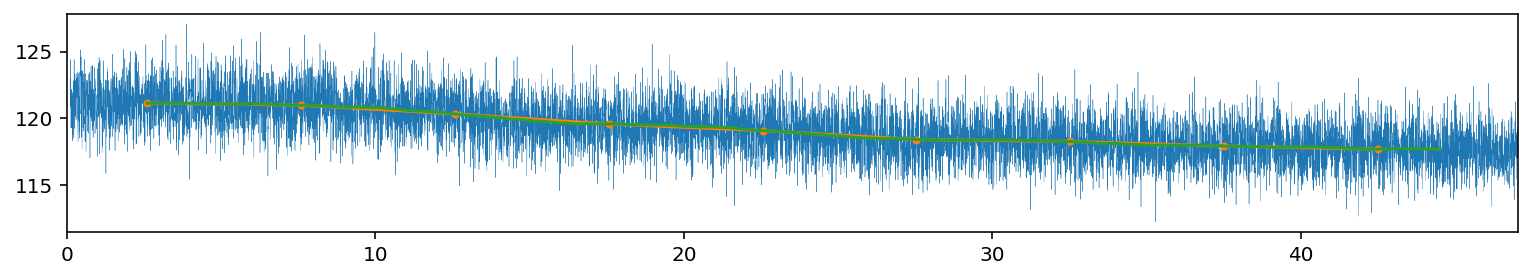

In [73]:
plt.figure(figsize=(13,2))
plt.plot(times,allProfile,lw=.2)
plt.xlim(0,times.max())
# tWin = 1000
t,x = rebin(times,tWin),rebin(allProfile,tWin)
# t = np.hstack([[0],t,[times.max()]])
plt.plot(t,x,".-")
t,x = moving_average(times,tWin),moving_average(allProfile,tWin)
plt.plot(t,x,"-")

In [103]:
# [f.max() for f in FirstFrames]

<BarContainer object of 9 artists>

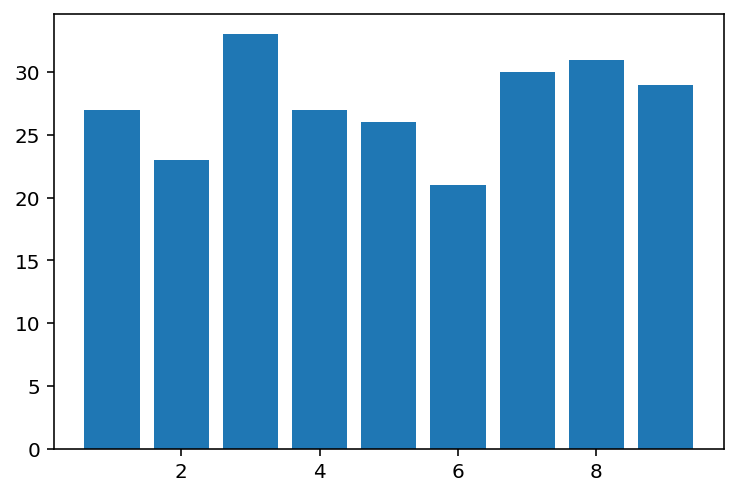

In [153]:
x = np.random.choice(image.flatten(),100000)
# plt.step(sorted(x),1+np.arange(len(x))-sum(x==0))
# plt.ylim(0,10)

x,y = np.array(tally(x)).T
y = y[x>0]
x = x[x>0]
y = y[x<10]
x = x[x<10]
plt.bar(x,y)
# plt.ylim(0,10)

In [154]:
frequency

439.44371939864084

In [116]:
image.shape[2]*mdf.loc[idx,"Y"]/100

3.187826008232118

In [200]:
tWin = len(image)//1000+1

In [201]:
profile = rebin(image.reshape(len(image),-1).mean(axis=1),tWin)

In [205]:
totT = mdf.loc[idx,"SizeT"]/mdf.loc[idx,'freq']

In [208]:
time = np.linspace(0,totT,len(profile))

In [211]:
IM = image[:100].mean(axis=0)
pxSize = mdf.loc[idx,"X"]
pxUnit = mdf.loc[idx,"[X]"]
rescale = 1./50
log=True

In [217]:
pxUnit

'µm'

In [245]:
%%time
def plotImage(IM,pxSize=1,pxUnit="µm",rescale=1./50,log=True,savePath = None, timeProfile = None):
    from matplotlib.colors import LogNorm
    upper = np.array([IM.shape[1]*pxSize,IM.shape[0]*pxSize])*rescale+1
    upper[0] += 3
    lower = upper.copy()
    if timeProfile is None:
        lower *= 0
    else:
        lower[1] = 3
    figsize = upper.copy()
    figsize[1] += lower[1]
    fig = plt.figure(figsize=figsize)
    rau = np.array([0,lower[1]/figsize[1],1-1./upper[0],upper[1]/figsize[1]])
    rau[0] += .07*rau[2]
#     rau[2] *= .9
    au  = fig.add_axes(rau)
    rcax = np.array([1-.5/upper[0],lower[1]/figsize[1],.2/upper[0],upper[1]/figsize[1]])
    rcax[1]  += .1*rcax[-1]
    rcax[-1] *= .8
    rcax[0]  += .05*rcax
    cax = fig.add_axes(rcax)
    im_ = au.imshow(IM,
               norm=LogNorm() if log else None,#vmin=1, vmax=np.log10(IM.max())),
               extent=(0,IM.shape[1]*pxSize,IM.shape[0]*pxSize,0))
    plt.colorbar(im_,cax=cax)
    au.set_xlabel("x [%s]"%pxUnit)
    au.set_ylabel("y [%s]"%pxUnit)
    yt = np.arange(0,np.ceil(IM.shape[0]*pxSize)+1e-10,10)
    xt = np.arange(0,np.ceil(IM.shape[1]*pxSize)+1e-10,20)
    au.set_yticks(yt);au.set_yticks(yt);
    au.set_xticks(xt);au.set_xticks(xt);

    if sum(lower)>0:
        ad  = fig.add_axes([0,0,1,lower[1]/figsize[1]*.8])
        time,profile = timeProfile
        ad.plot(time,profile)
        ad.set_xlim(0,totT)
        ad.set_xlabel("time [s]")
    if savePath is not None:
        fig.tight_layout()
        fig.savefig(savePath)
        plt.close(fig)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 13.1 µs


In [268]:
%%time
def plotImage(IM,pxSize=1,pxUnit="µm",rescale=1./30,log=True,savePath = None):
    from matplotlib.colors import LogNorm
    figsize = np.array([IM.shape[1]*pxSize,IM.shape[0]*pxSize])*rescale
#     figsize[1] += 1
    fig = plt.figure(figsize=figsize)
    plt.subplot(111)
    plt.imshow(IM,
               norm=LogNorm() if log else None,#vmin=1, vmax=np.log10(IM.max())),
               extent=(0,IM.shape[1]*pxSize,IM.shape[0]*pxSize,0))
    plt.colorbar(im_,shrink = .8)
    plt.xlabel("x [%s]"%pxUnit)
    plt.ylabel("y [%s]"%pxUnit)
    yt = np.arange(0,np.ceil(IM.shape[0]*pxSize)+1e-10,10)
    xt = np.arange(0,np.ceil(IM.shape[1]*pxSize)+1e-10,20)
    plt.yticks(yt,fontsize = 12)
    plt.xticks(xt,fontsize = 12)
    if savePath is not None:
        fig.tight_layout()
        fig.savefig(savePath)
        plt.close(fig)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 11.9 µs


[10.37565202  2.593913  ]
[10.37565202  5.593913  ]
CPU times: user 72 ms, sys: 2.87 ms, total: 74.8 ms
Wall time: 73.5 ms


Text(0.5, 0, 'time [s]')

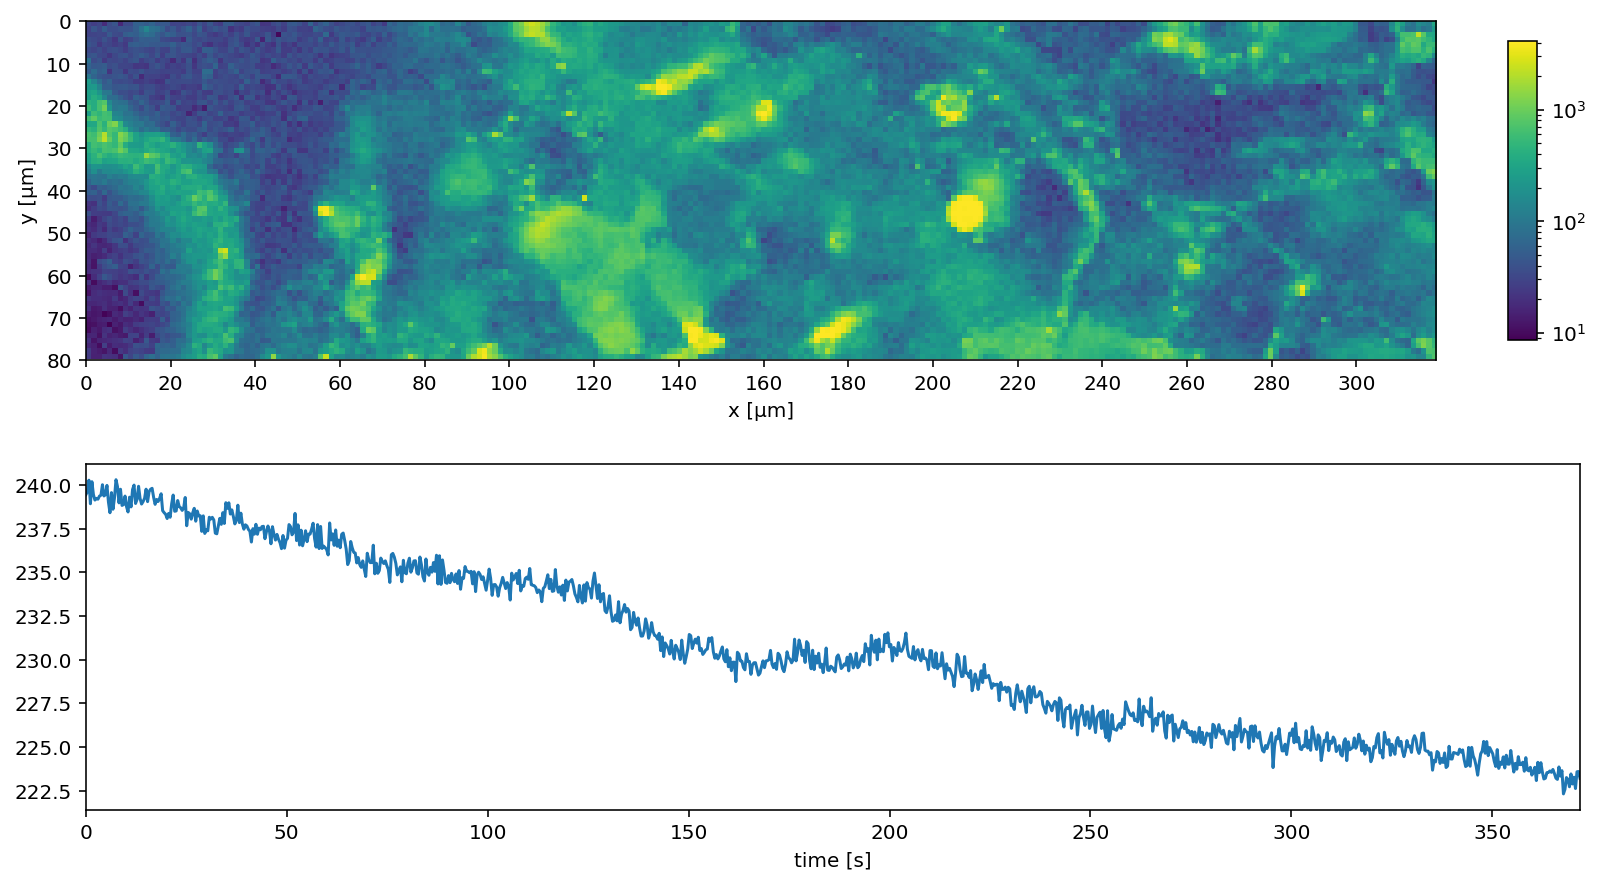

In [215]:
%%time
from matplotlib.colors import LogNorm
upper = np.array([IM.shape[1]*pxSize,IM.shape[0]*pxSize])*rescale+1
upper[0] += 3
print (upper)
lower = upper.copy()
lower[1] = 3
figsize = upper.copy()
figsize[1] += lower[1]
print (figsize)
fig = plt.figure(figsize=figsize)
au  = fig.add_axes([0,lower[1]/figsize[1],1-1./upper[0],upper[1]/figsize[1]])
rcax = np.array([1-.5/upper[0],lower[1]/figsize[1],.2/upper[0],upper[1]/figsize[1]])
rcax[1]  += .1*rcax[-1]
rcax[-1] *= .8
cax = fig.add_axes(rcax)
ad  = fig.add_axes([0,0,1,lower[1]/figsize[1]*.8])
im_ = au.imshow(IM,
           norm=LogNorm() if log else None,#vmin=1, vmax=np.log10(IM.max())),
           extent=(0,IM.shape[1]*pxSize,IM.shape[0]*pxSize,0))
plt.colorbar(im_,cax=cax)
au.set_xlabel("x [%s]"%pxUnit)
au.set_ylabel("y [%s]"%pxUnit)
yt = np.arange(0,np.ceil(IM.shape[0]*pxSize)+1e-10,10)
xt = np.arange(0,np.ceil(IM.shape[1]*pxSize)+1e-10,20)
au.set_yticks(yt);au.set_yticks(yt);
au.set_xticks(xt);au.set_xticks(xt);

ad.plot(time,profile)
ad.set_xlim(0,totT)
ad.set_xlabel("time [s]")

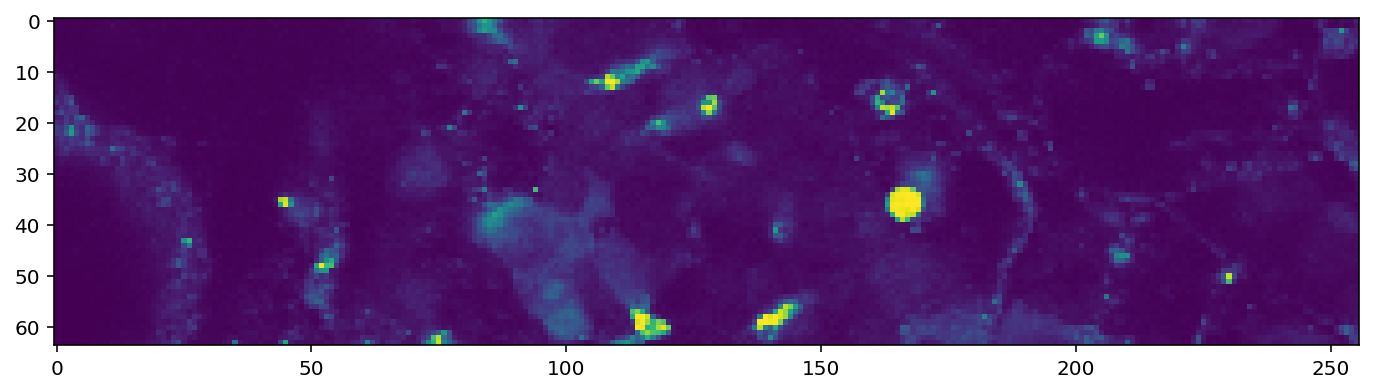

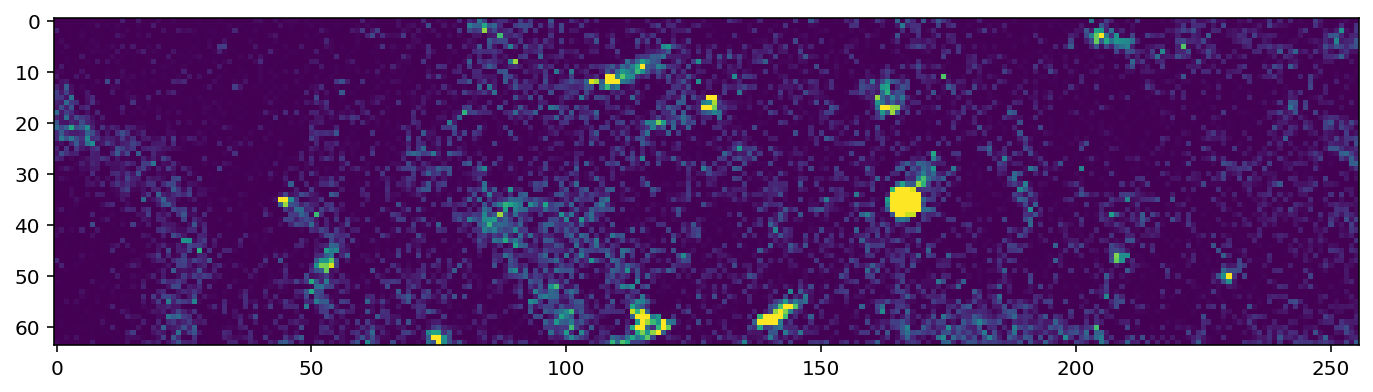

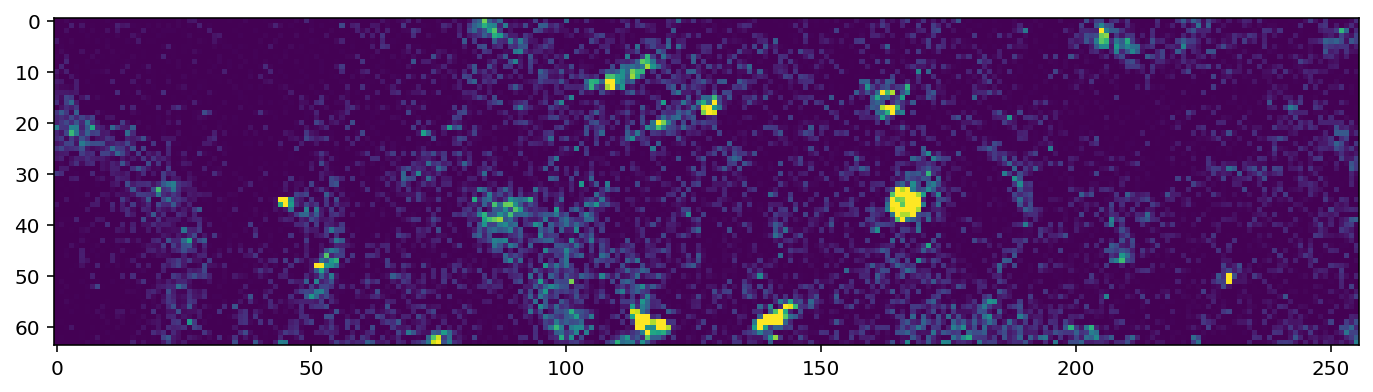

In [153]:
for im in [image[:100].mean(axis=0),image[0],image[1]]:
    plt.figure(figsize=(12,3))
    plt.imshow(im)
    plt.show()

# Line Scan

In [139]:
# del LineT

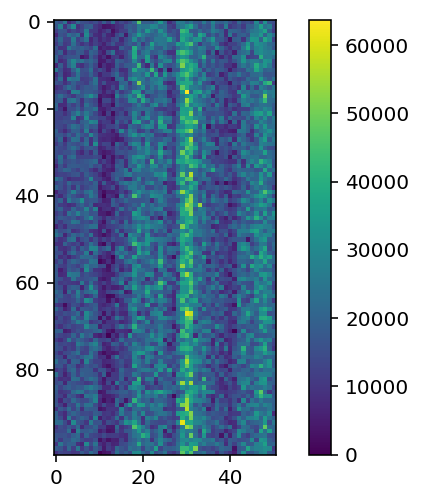

In [32]:
tWin = 10
pxWin = 10
plt.imshow(rebin(rebin(LineT[:1000],tWin,axis=0,norm=False),pxWin,axis=1,norm=False))
plt.colorbar()

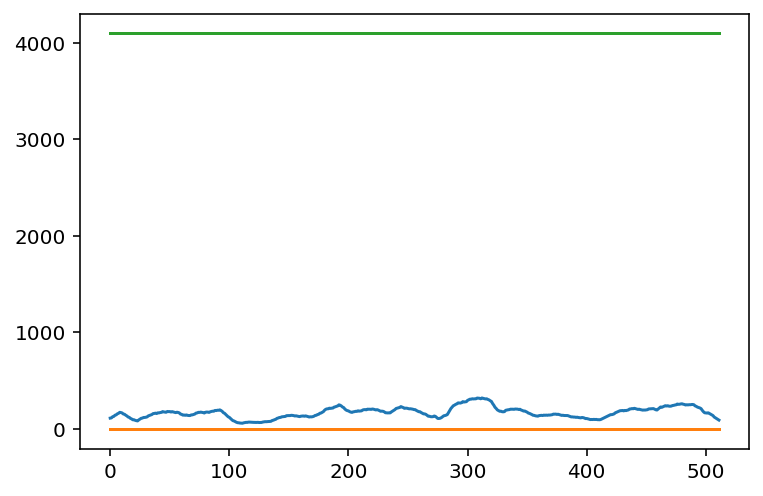

In [35]:
plt.plot(np.mean(LineT,axis=0))
plt.plot(np.min (LineT,axis=0))
plt.plot(np.max (LineT,axis=0))

In [37]:
iShow = np.argmin(LineT.mean(axis=0))

In [106]:
from general_functions import autocorr

In [109]:
xr = np.arange(1,10)
# y,ye = autocorr(LineT.T[iShow],xr,nsplits=4)
# plt.errorbar(xr,y,ye)

In [111]:
# plt.figure(figsize=(13,3))
# plt.plot(rebin(LineT[:,iShow],2000,norm=False))

In [112]:
maxv = LineT.max()

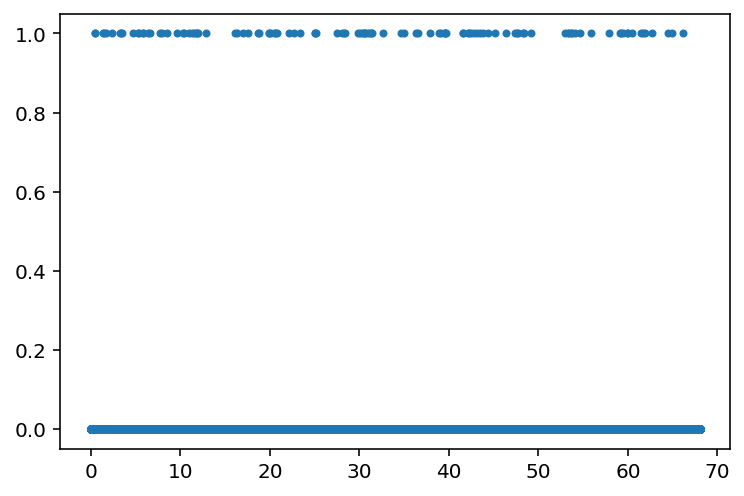

In [119]:
binn = (LineT[:,iShow]==maxv).astype(float)
plt.plot(times,binn,".")

In [121]:
# y,ye = autocorr(binn,xr,nsplits=10)
# plt.errorbar(xr,y,ye)

In [129]:
LineT.T[iShow]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

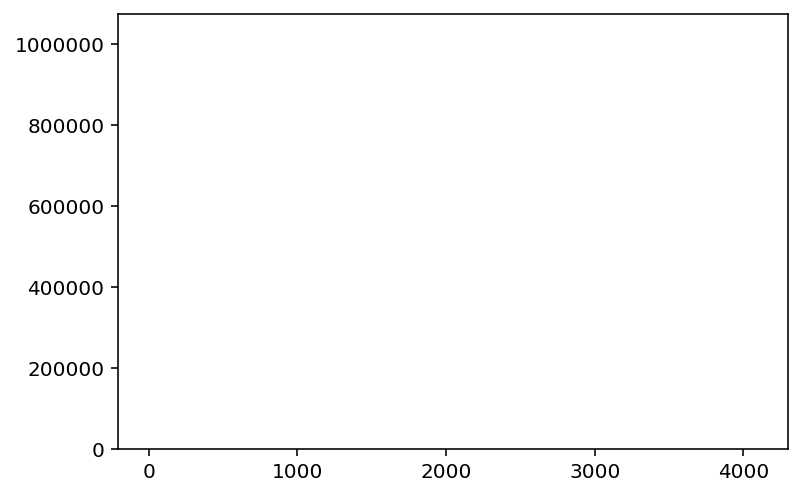

In [126]:
plt.hist(LineT.T[iShow],1000);

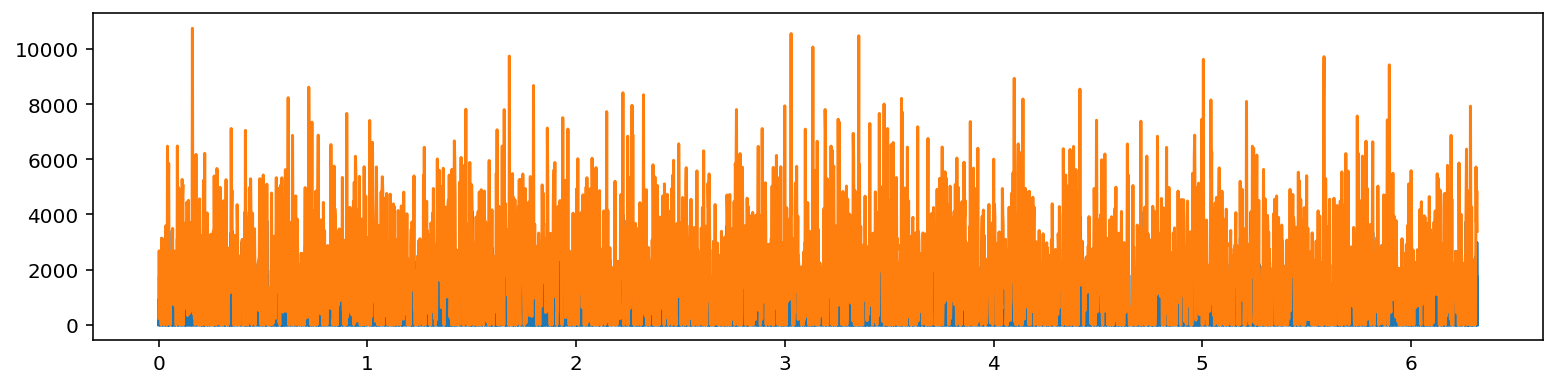

In [97]:
plt.figure(figsize=(13,3))
imax = 100000
plt.plot(times[:imax],LineT[:imax,iShow])
tWin = 30
plt.plot(rebin(times[:imax],tWin),
         rebin(LineT[:imax,iShow],tWin,norm=False))

# plt.yscale("log")

In [24]:
np.sum(LineT == LineT.max())

657715

In [ ]:
allProfile = LineT.)

In [22]:
tWin = 100
iShow = 100
plt.plot(rebin(times,tWin),)

array([0.00000000e+00, 6.31875406e-05, 1.26375081e-04, ...,
       6.80037581e+01, 6.80038213e+01, 6.80038845e+01])

CPU times: user 66.8 ms, sys: 3.24 ms, total: 70 ms
Wall time: 49.5 ms


''

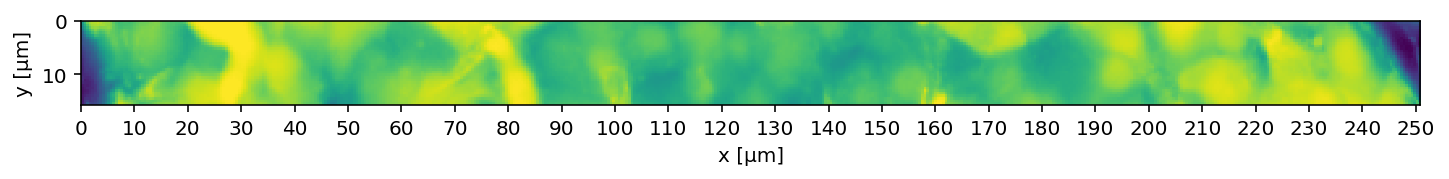

In [145]:
%%time
plt.figure(figsize=(12,8))
plt.imshow(np.log10(image.mean(axis=0).T),
           extent=(
               0,image.shape[1]*mdf.loc[idx,"X"],
               image.shape[2]*mdf.loc[idx,"Y"],0
           ))
plt.xlabel("x [%s]"%mdf.loc[idx,"[X]"])
plt.ylabel("y [%s]"%mdf.loc[idx,"[Y]"])
plt.xticks(np.arange(0,image.shape[1]*mdf.loc[idx,"X"],10));
plt.yticks(np.arange(0,np.ceil(image.shape[2]*mdf.loc[idx,"Y"])+1e-10,10));
""

In [150]:
image.max()

255

In [146]:
allProfile = image.mean(axis=(1,2))

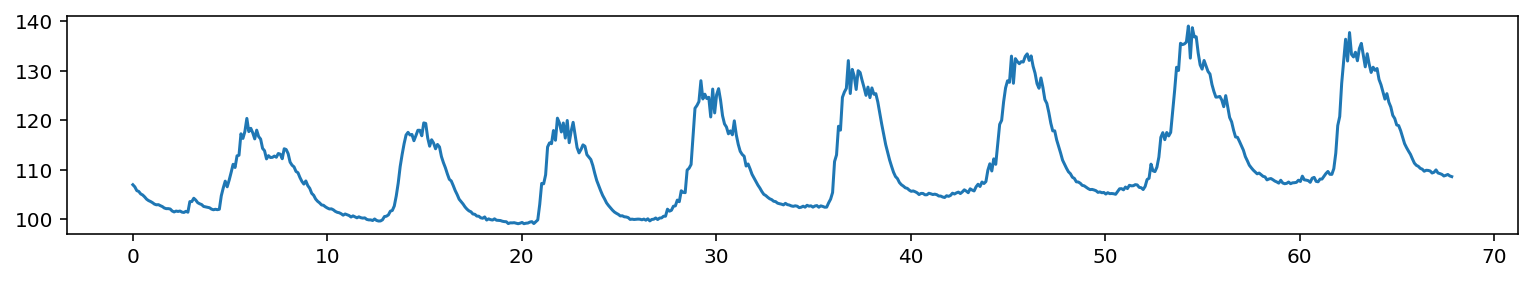

In [147]:
plt.figure(figsize=(13,2))
plt.plot(times,allProfile)

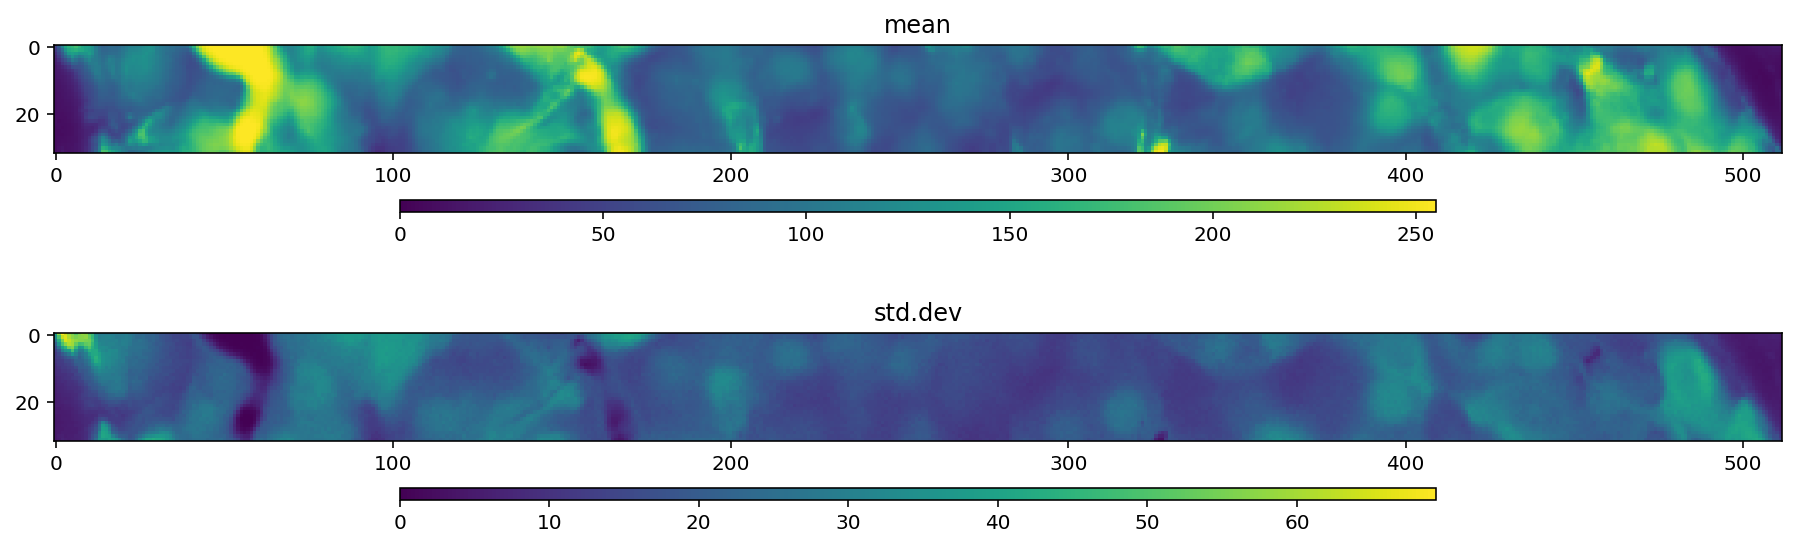

In [148]:
showAside = False
fig = plt.figure(figsize=(12,4))
if showAside:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]
else:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]

for X,ax,cax,name in zip([image.std(axis=0),image.mean(axis=0)],axs,caxs,["std.dev","mean"]):
    im_ = ax.imshow(X.T, vmin=0)
    plt.colorbar(im_, cax=cax,orientation= "vertical" if showAside else "horizontal")
    ax.set_title(name)

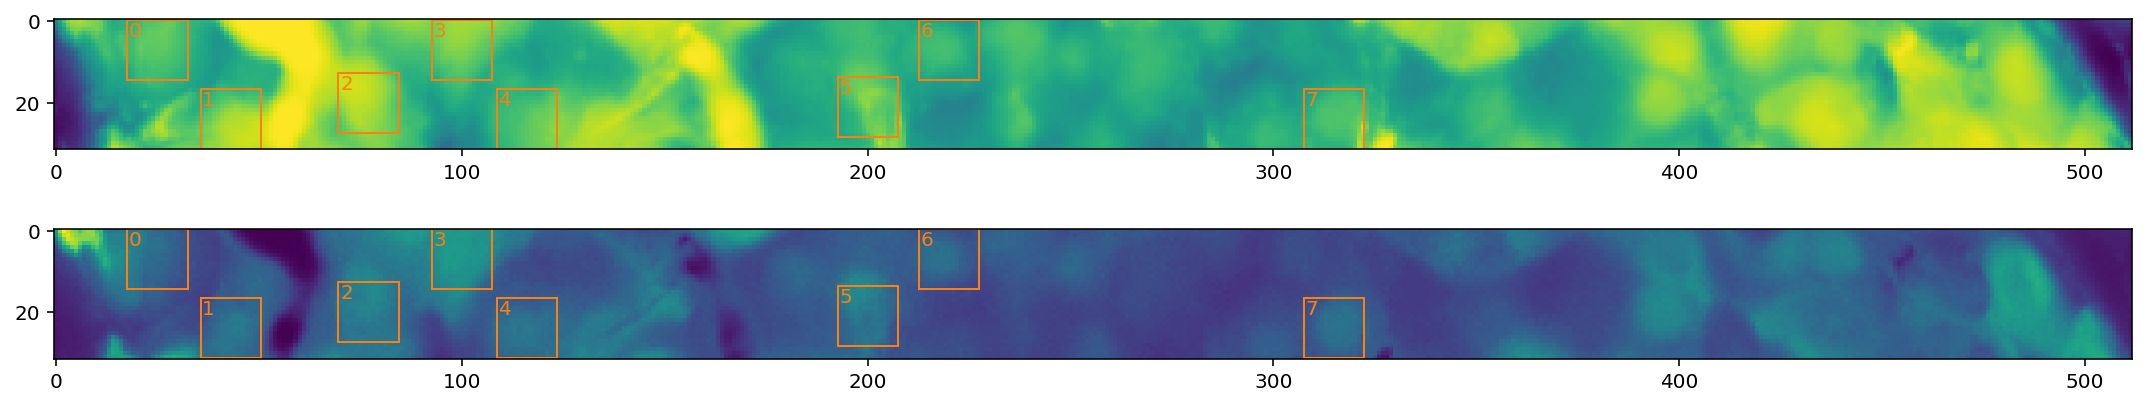

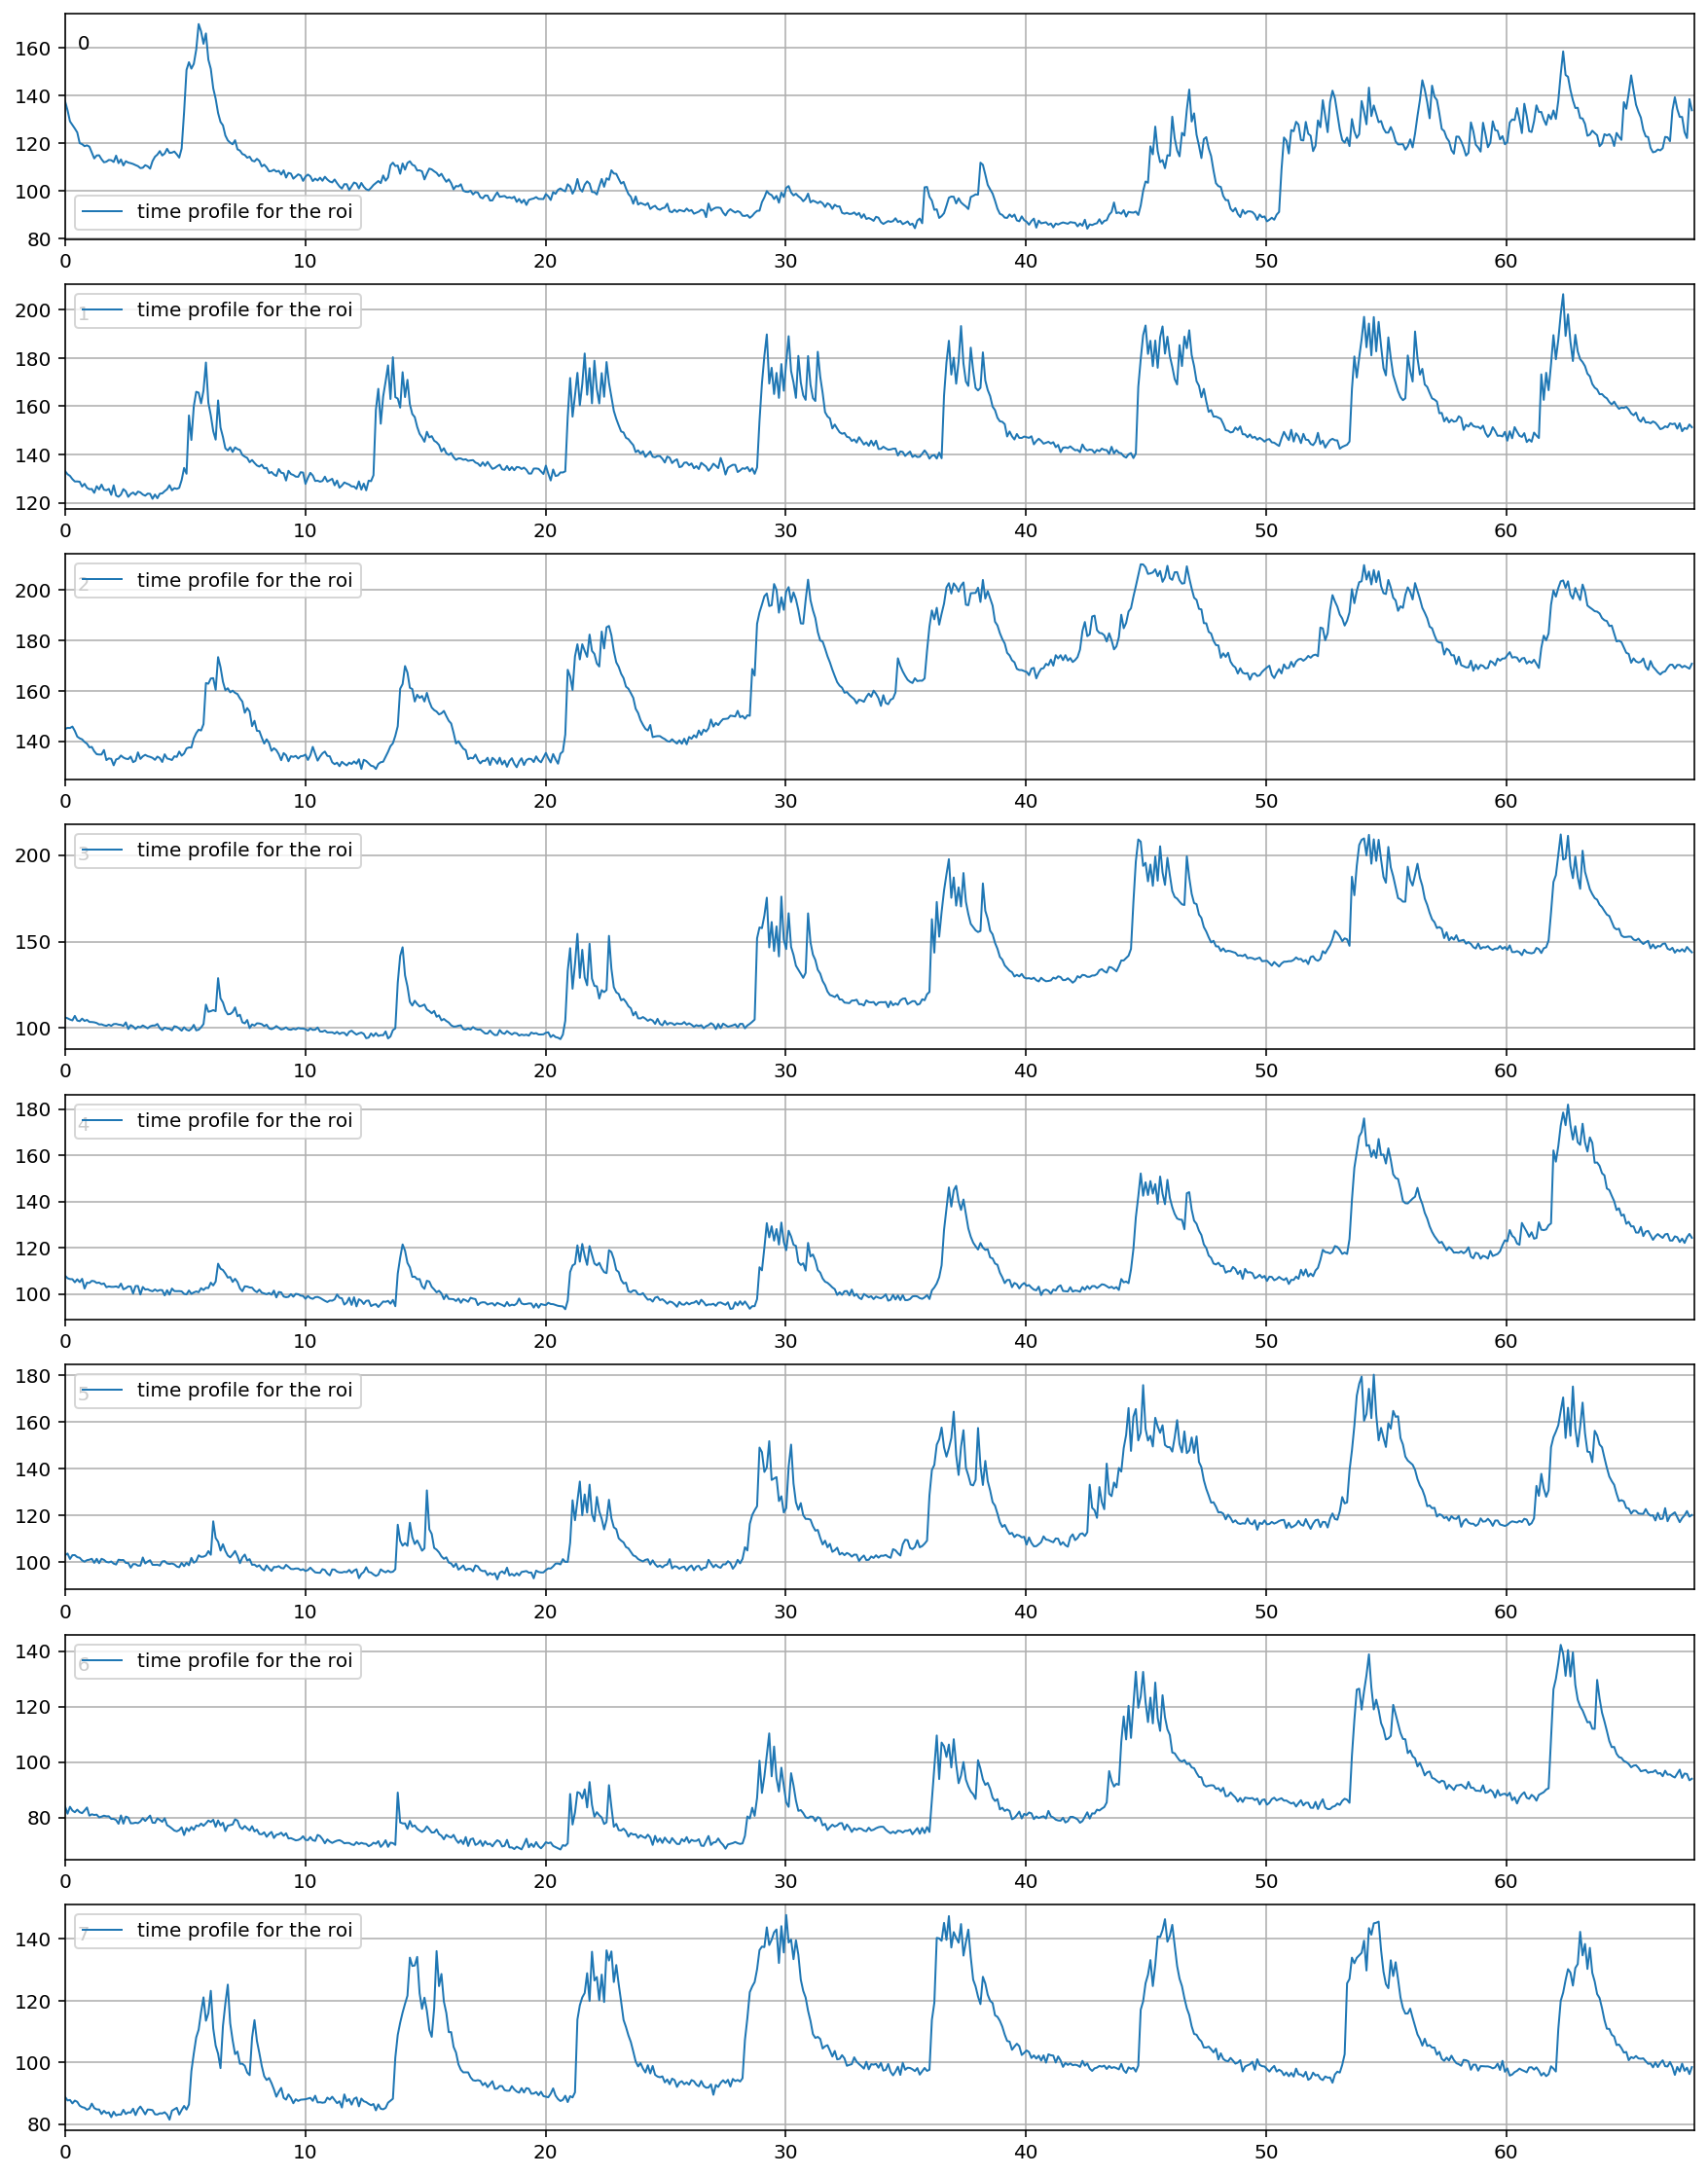

In [90]:
multiProfilePlotWithRoi(
    pxShows=[(25,7),(43,24),(77,20),(100,7),(116,24),(200,21),(220,7),(315,24)],
    pxWin=7,
#     timeWindow=(0,10),
#     timeAverageWindow=2,
    times_=times,
    image_=image,
    firstDeriv=False,
    stdDev=True,
    showRaw=False,
)

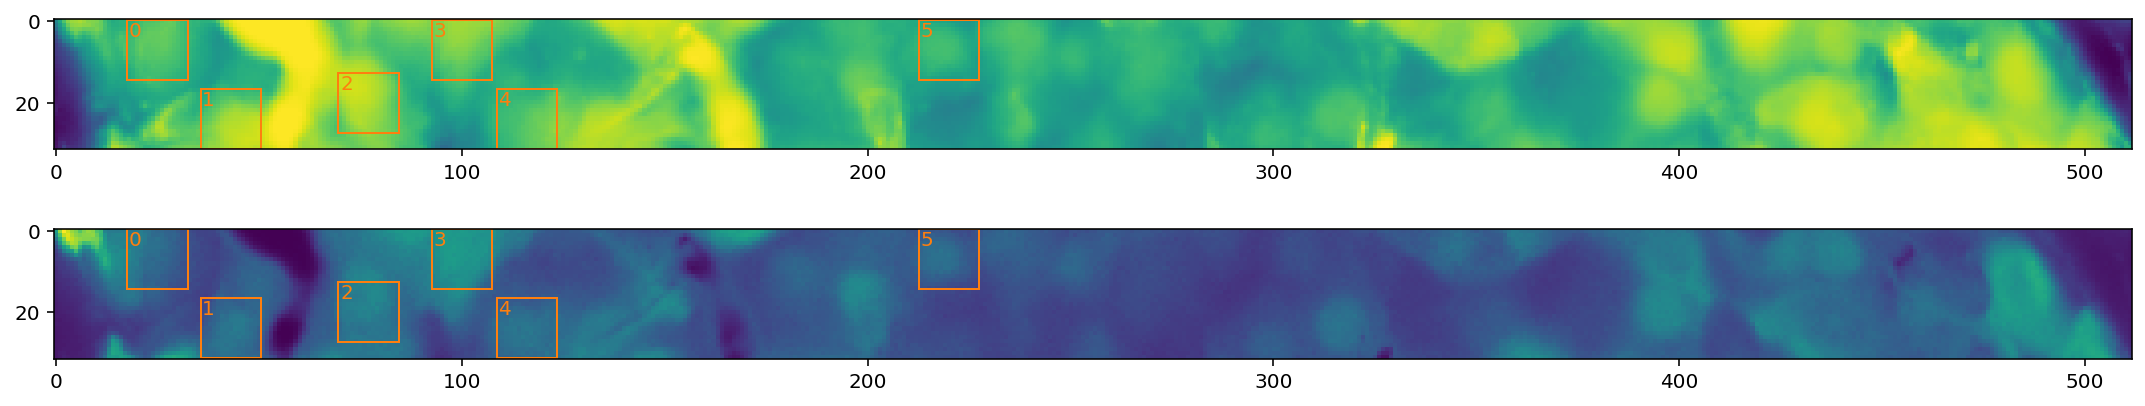

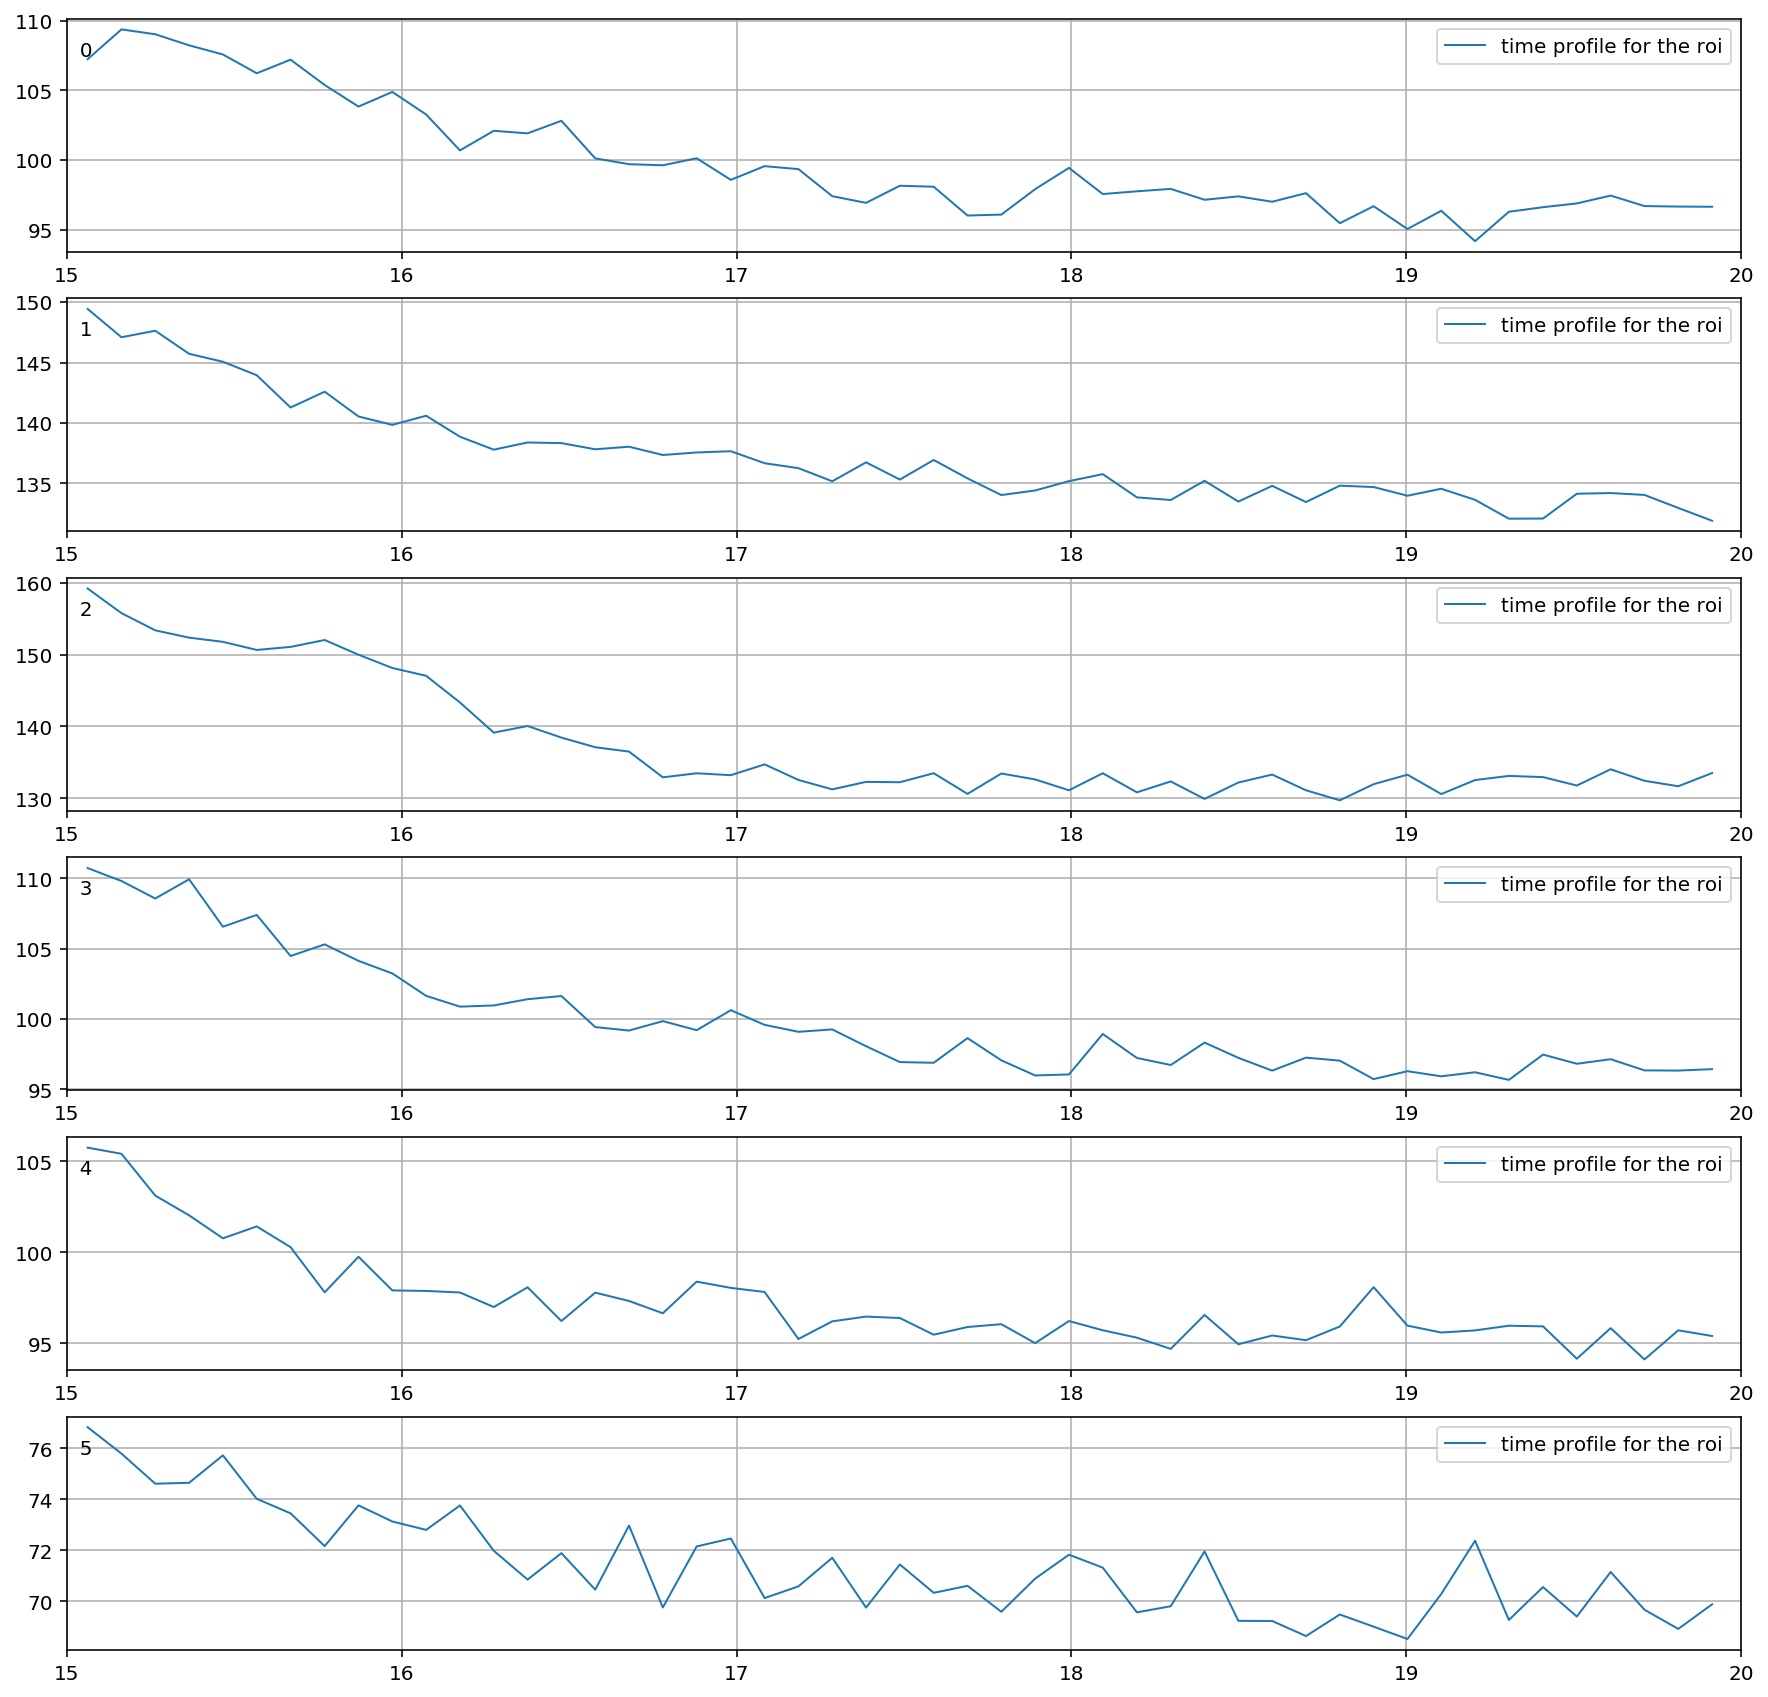

In [88]:
multiProfilePlotWithRoi(
    pxShows=[(25,7),(43,24),(77,20),(100,7),(116,24),(220,7)],
    pxWin=7,
    timeWindow=(15,20),
#     timeAverageWindow=2,
    times_=times,
    image_=image,
    firstDeriv=False,
    stdDev=True,
    showRaw=False,
)

## Series051

In [91]:
idx = 18#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
dimensions = OrderedDict([(coord,mdf.loc[idx,"Size"+coord]) for coord in "XYZCT"])
image = np.array([
            rdr.read(series=idx, rescale=False,t=t, ).T for t in range(dimensions["T"])
        ])

In [92]:
mdf.loc[[idx]]

Name     AcquisitionDate  SizeX  SizeY  SizeT  SizeC  SizeZ  \
18  Series051 2019-05-16 14:14:16    512     32  12524      1      1   

         freq         X [X]         Y [Y]   Z   [Z]  nAverageLine_1 ScanMode  
18  82.439682  0.489878  µm  0.489878  µm NaN  None               3      xyt

In [93]:
times = getTimes(idx)
dt = np.diff(times).mean()
lineScaneMode = mdf.loc[idx,"ScanMode"]=="xt"
if lineScaneMode:
    LineT = np.vstack(image)
    dt = dt/len(image[0])
    times = np.arange(len(LineT))*dt

frequency = 1./dt

In [94]:
frequency

82.4396823237758

CPU times: user 273 ms, sys: 2.66 ms, total: 276 ms
Wall time: 256 ms


''

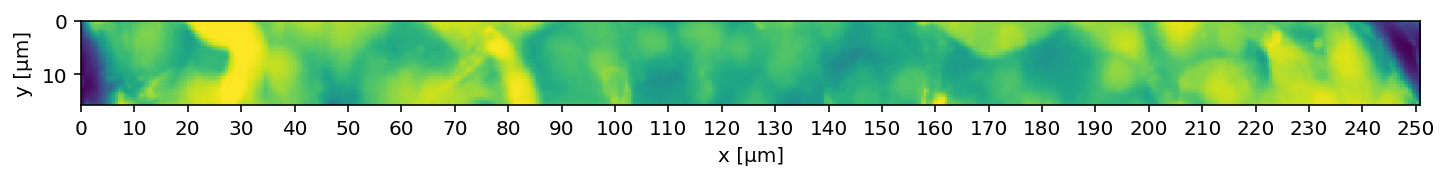

In [95]:
%%time
plt.figure(figsize=(12,8))
plt.imshow(np.log10(image.mean(axis=0).T),
           extent=(
               0,image.shape[1]*mdf.loc[idx,"X"],
               image.shape[2]*mdf.loc[idx,"Y"],0
           ))
plt.xlabel("x [%s]"%mdf.loc[idx,"[X]"])
plt.ylabel("y [%s]"%mdf.loc[idx,"[Y]"])
plt.xticks(np.arange(0,image.shape[1]*mdf.loc[idx,"X"],10));
plt.yticks(np.arange(0,np.ceil(image.shape[2]*mdf.loc[idx,"Y"])+1e-10,10));
""

In [96]:
allProfile = image.mean(axis=(1,2))

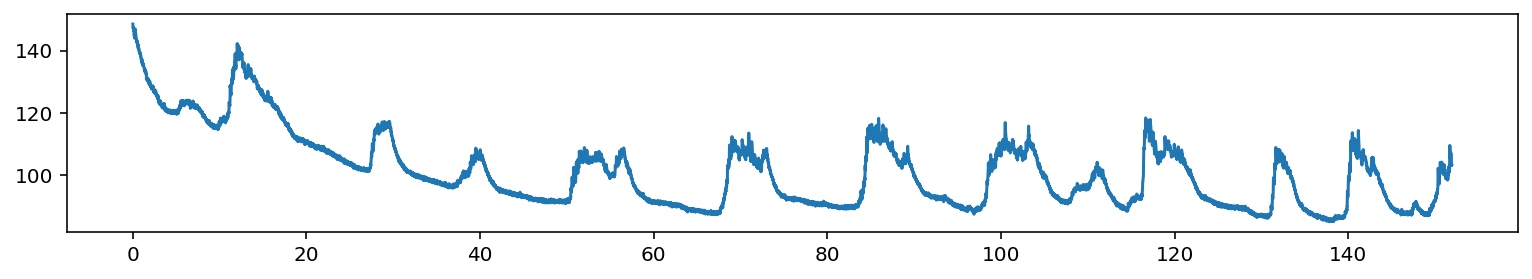

In [97]:
plt.figure(figsize=(13,2))
plt.plot(times,allProfile)

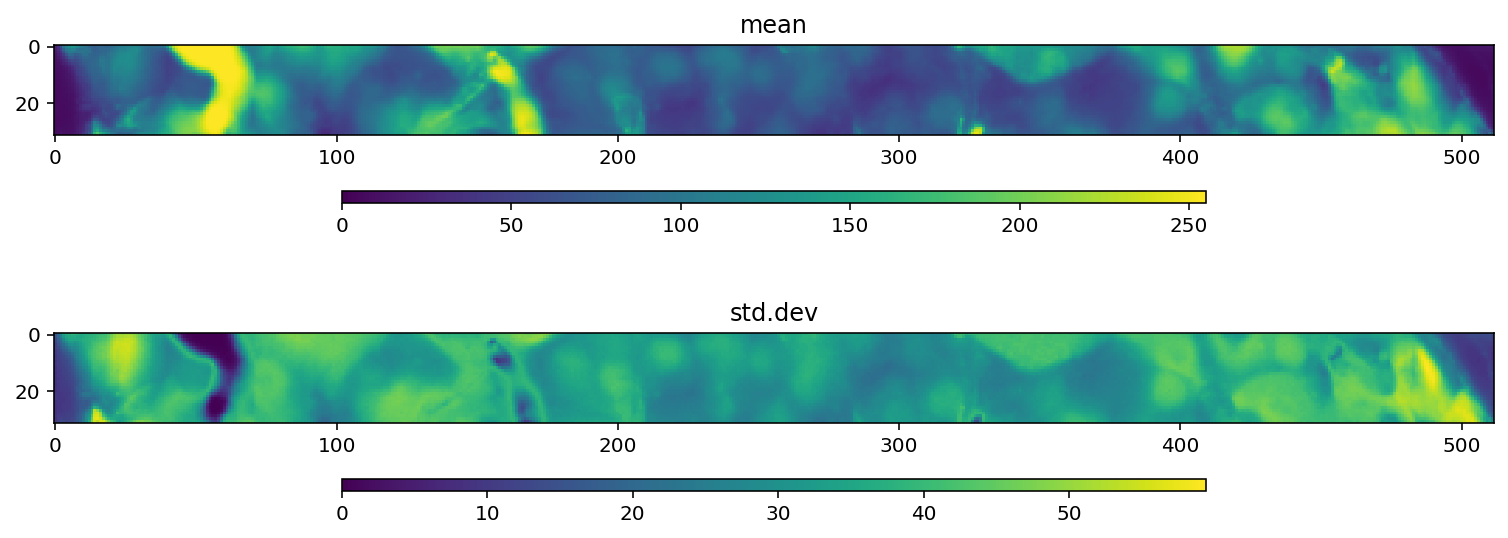

In [98]:
showAside = False
fig = plt.figure(figsize=(10,4))
if showAside:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]
else:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]

for X,ax,cax,name in zip([image.std(axis=0),image.mean(axis=0)],axs,caxs,["std.dev","mean"]):
    im_ = ax.imshow(X.T, vmin=0)
    plt.colorbar(im_, cax=cax,orientation= "vertical" if showAside else "horizontal")
    ax.set_title(name)

In [122]:
filename

'Experiment.lif'

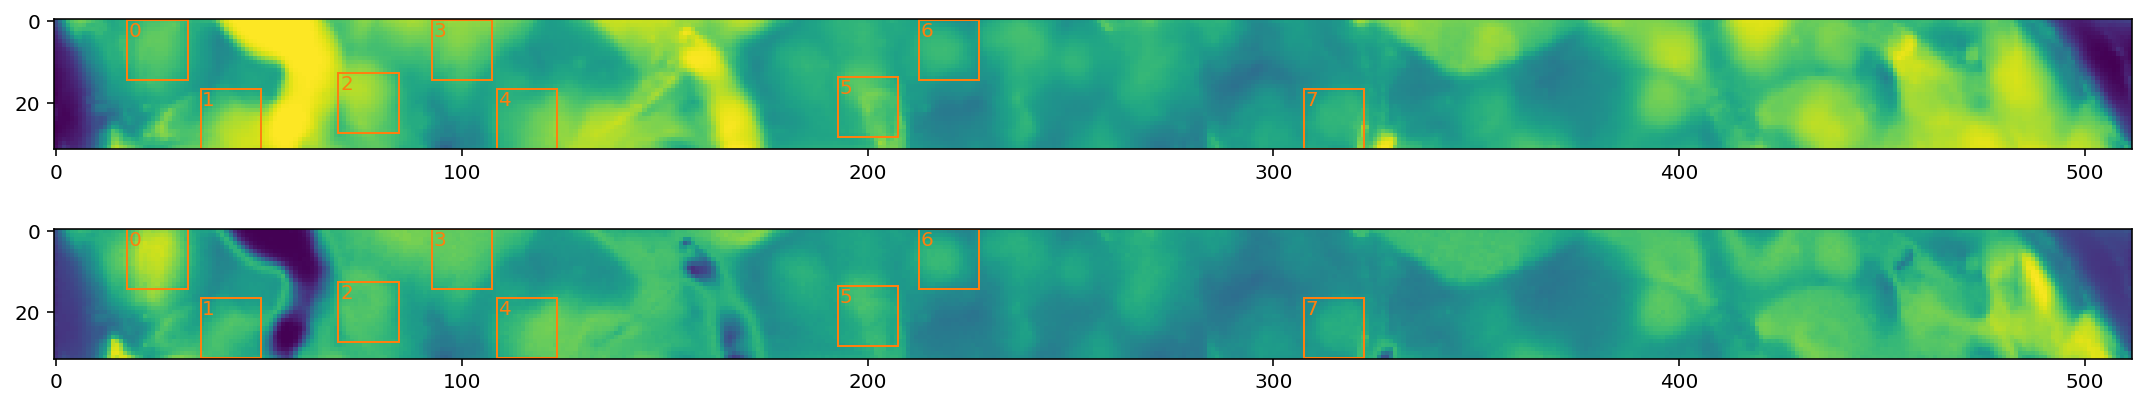

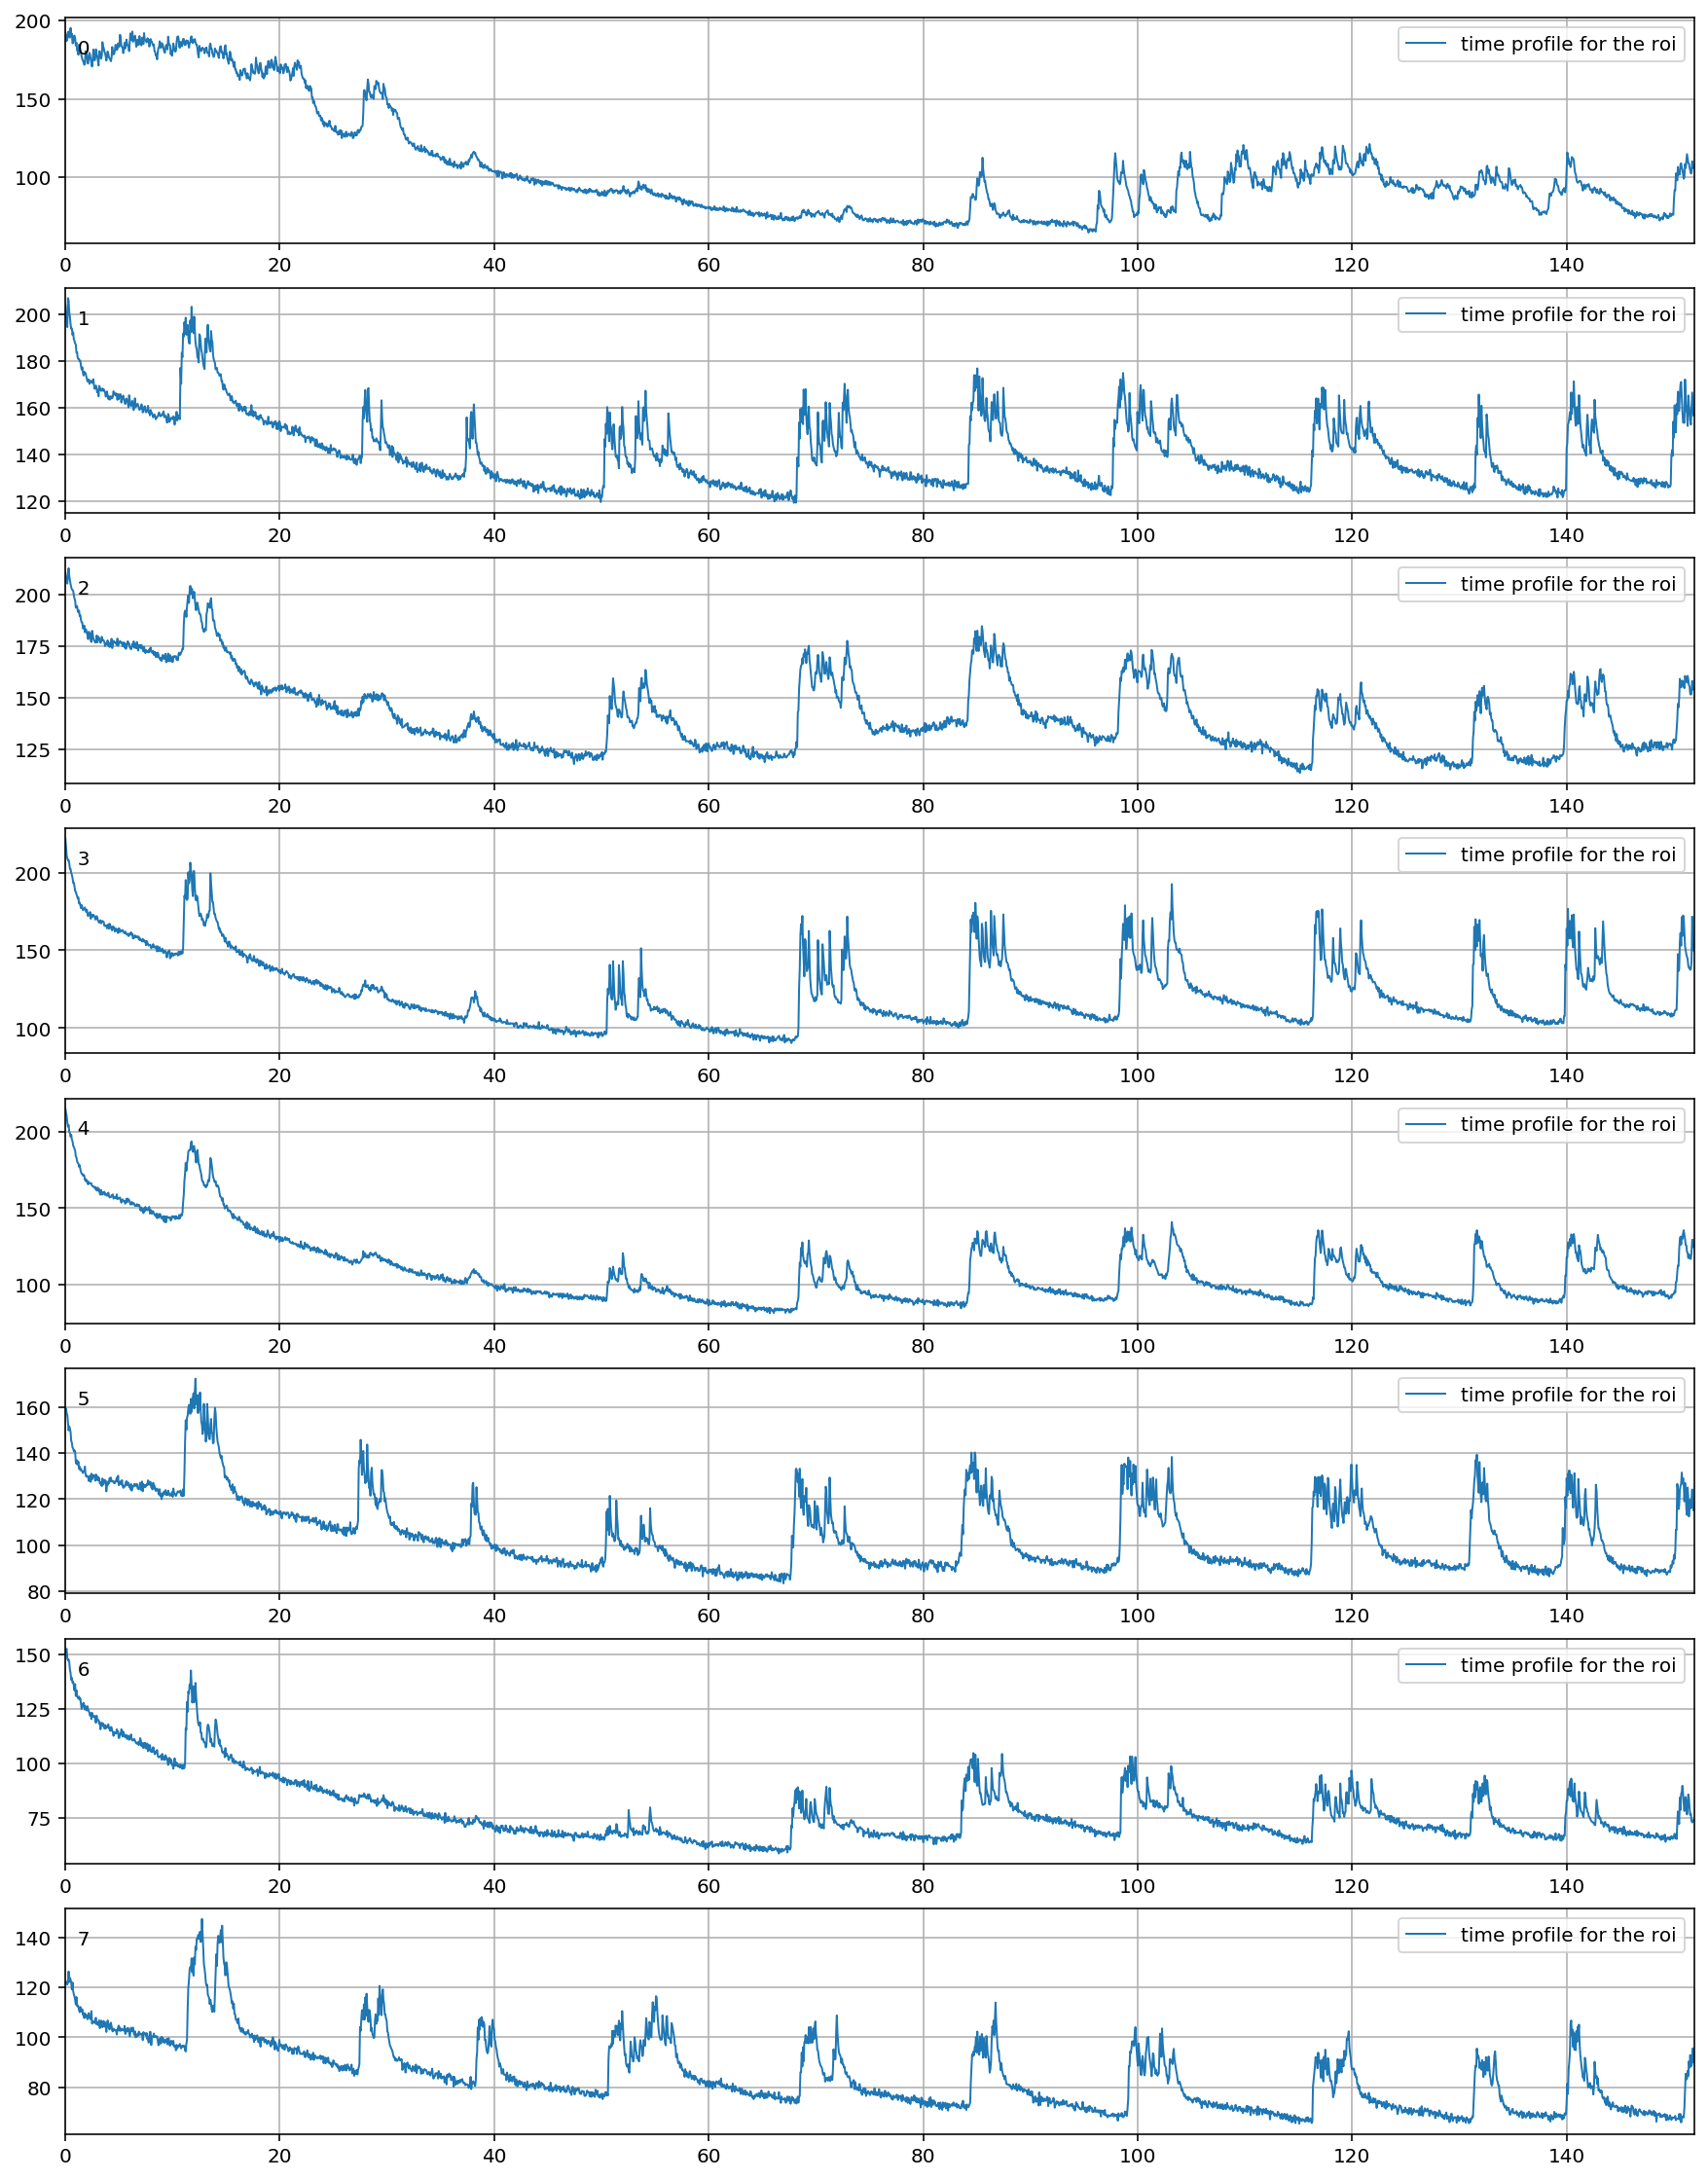

In [100]:
multiProfilePlotWithRoi(
    pxShows=[(25,7),(43,24),(77,20),(100,7),(116,24),(200,21),(220,7),(315,24)],
    pxWin=7,
#     timeWindow=(0,10),
    timeAverageWindow=5,
    times_=times,
    image_=image,
    firstDeriv=False,
    stdDev=True,
    showRaw=False,
)

In [123]:
mdf.loc[idx]

Name                         Series051
AcquisitionDate    2019-05-16 14:14:16
SizeX                              512
SizeY                               32
SizeT                            12524
SizeC                                1
SizeZ                                1
freq                           82.4397
X                             0.489878
[X]                                 µm
Y                             0.489878
[Y]                                 µm
Z                                  NaN
[Z]                               None
nAverageLine_1                       3
ScanMode                           xyt
Name: 18, dtype: object

In [124]:
.5*17

8.5

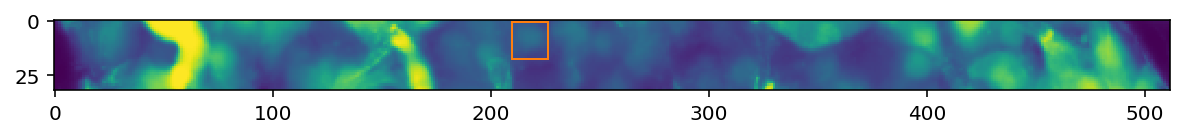

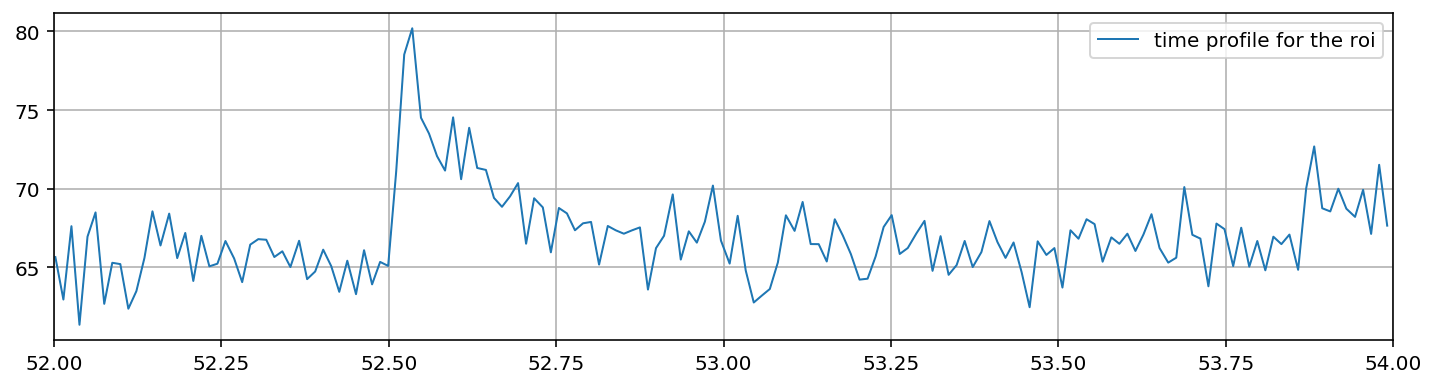

In [106]:
t,x = plotTimeProfileForROI((218,9),8,
#                             timeAverageWindow=3,
                            timeWindow=(52,54)
                           )

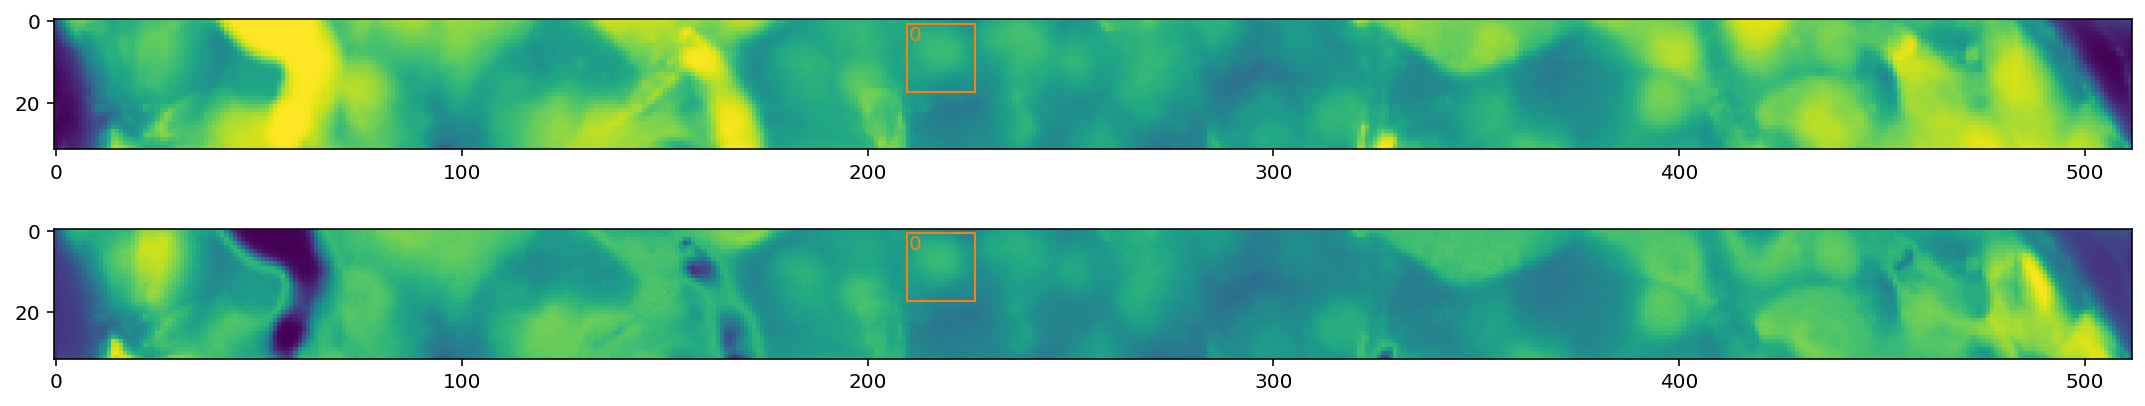

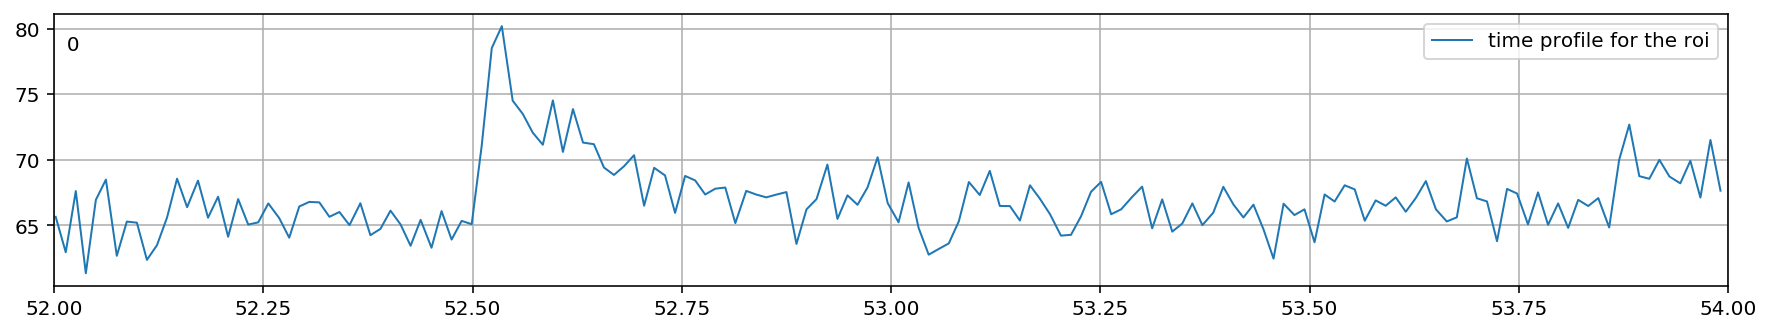

In [134]:
multiProfilePlotWithRoi(
    pxShows=[(218,9)],
    pxWin=8,
    timeWindow=(52,54),
    timeAverageWindow=1,
    times_=times,
    image_=image,
    firstDeriv=False,
    stdDev=True,
    showRaw=False,
)

In [139]:
pxWin=4
rois = [(213+i*(2*pxWin+1),0+pxWin+j*(2*pxWin+1)) for i in range(2) for j in range(2)]
rois+=[]

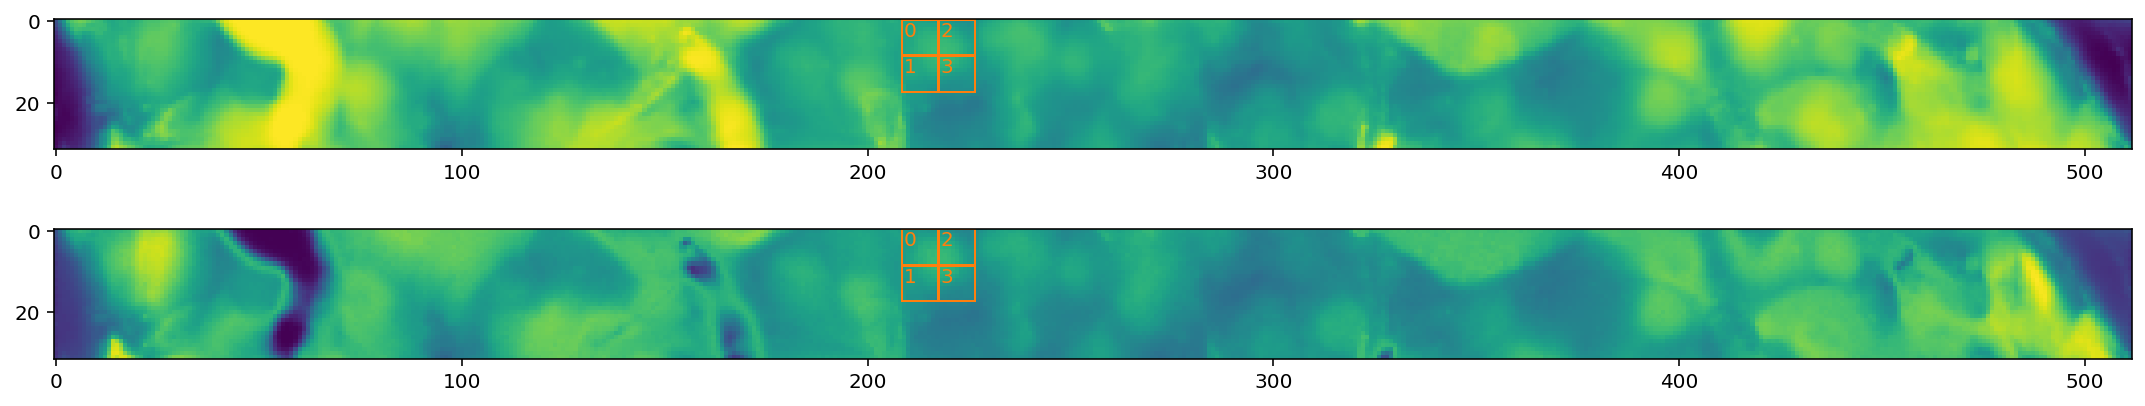

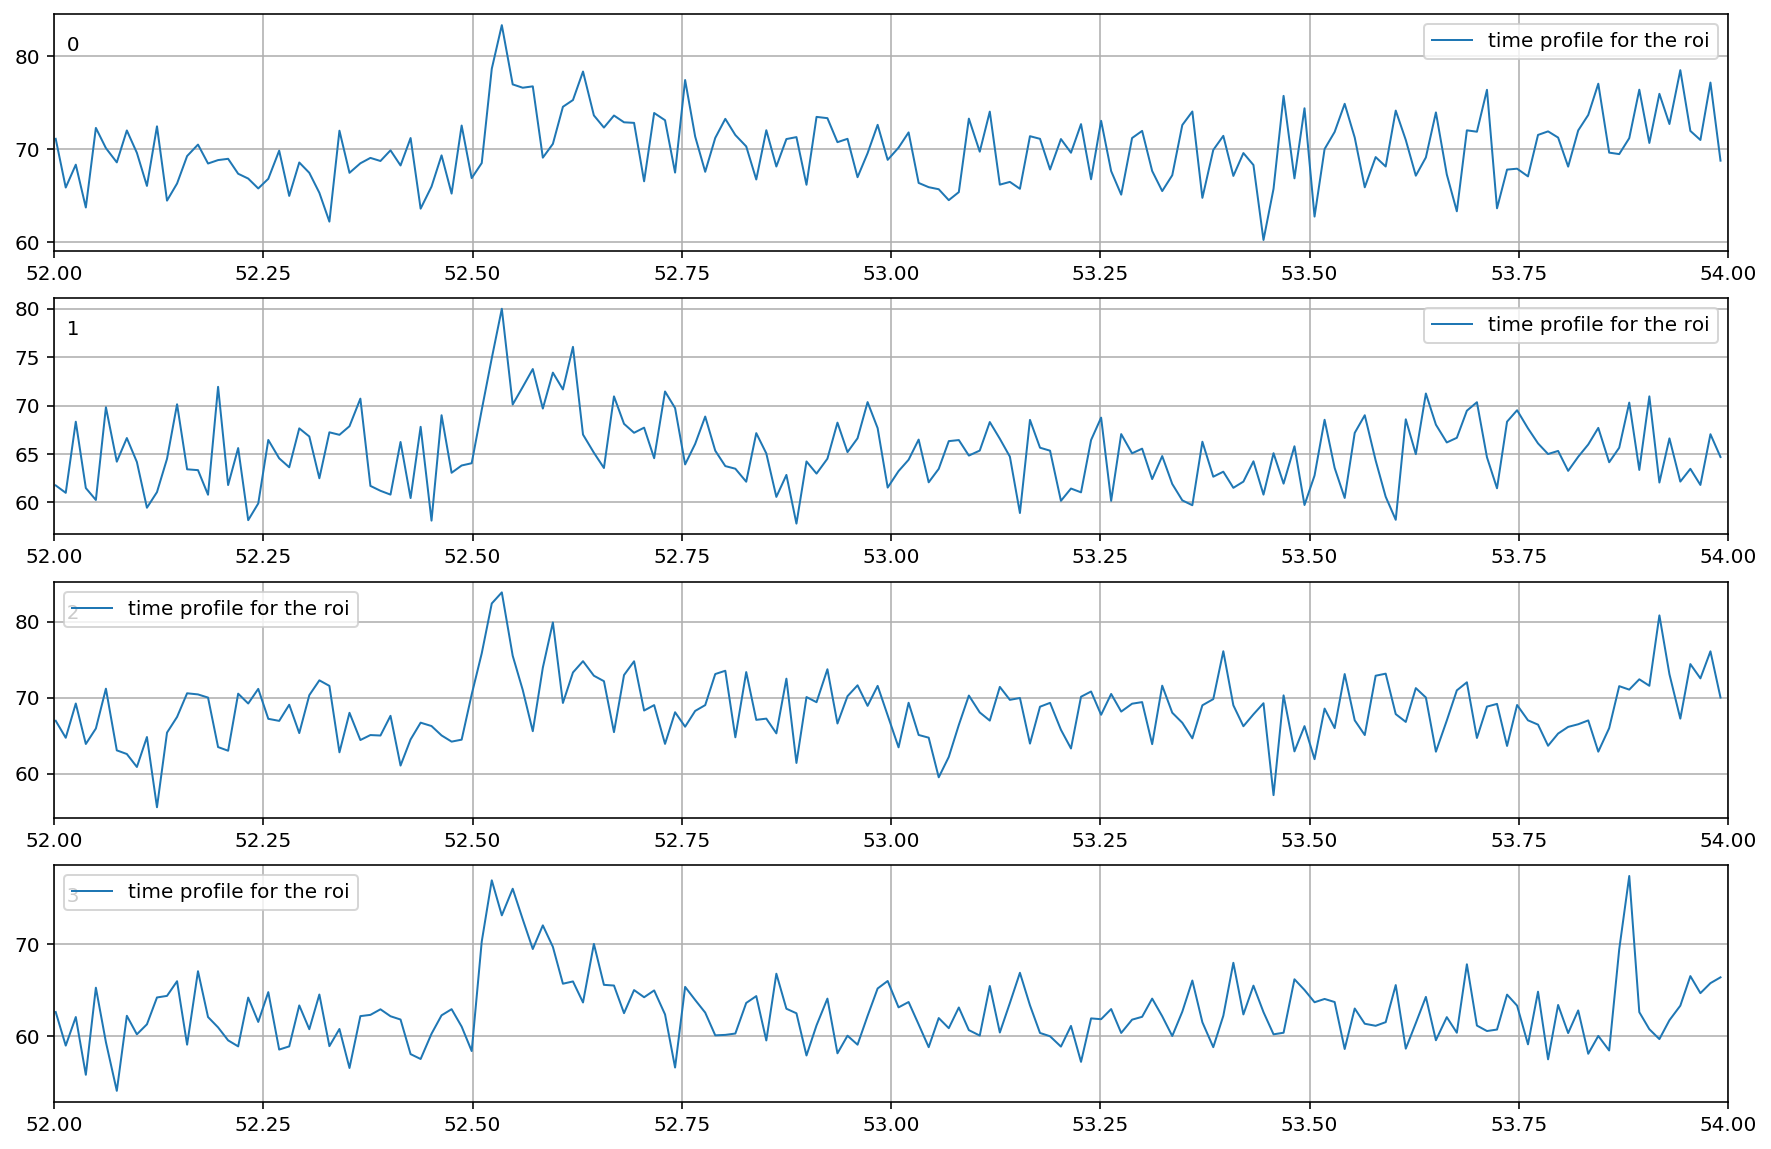

In [140]:
multiProfilePlotWithRoi(
    pxShows=rois,
    pxWin=pxWin,
    timeWindow=(52,54),
    timeAverageWindow=1,
    times_=times,
    image_=image,
    firstDeriv=False,
    stdDev=True,
    showRaw=False,
)

In [27]:
# y = x-np.percentile(x,5)
# y = y/(np.diff(y)).std()
# plt.figure(figsize=(10,3))
# ax = plt.subplot(111)
# # Fit(t,y,ax=ax,nPeaks=10,verbose=False)
# PS = manyFit(t,y,verbose=True,toll = .01)
# ax.plot(t,y)
# ax.plot(t,multiFun(t,PS))

In [85]:
mdf["AcquisitionDate"][28:34]-mdf.loc[29,"AcquisitionDate"]

28   -1 days +23:52:04
29            00:00:00
30            00:00:15
31            00:00:21
32            00:00:28
33                 NaT
Name: AcquisitionDate, dtype: timedelta64[ns]

In [72]:
%%time
Coll = OrderedDict()
for idx in range(29,33):    
    Name = mdf.loc[idx,"Name"]
    dimensions = OrderedDict([(coord,mdf.loc[idx,"Size"+coord]) for coord in "XYZCT"])
    image = np.array([
                rdr.read(series=idx, rescale=False,t=t, ) for t in range(dimensions["T"])
            ])
    AbsT = (mdf.loc[idx,"AcquisitionDate"]-mdf.loc[29,"AcquisitionDate"]).total_seconds()
    
    times = getTimes(idx)
    dt = np.diff(times).mean()
    lineScaneMode = mdf.loc[idx,"ScanMode"]=="xt"
    if lineScaneMode:
        LineT = np.vstack(image)
        dt = dt/len(image[0])
        times = np.arange(len(LineT))*dt
    
    frequency = 1./dt
    Coll[Name] = {
        "t0": AbsT,
        "times": times,
        "LineT": LineT,
        "frequency": frequency,
    }

CPU times: user 2.25 s, sys: 448 ms, total: 2.69 s
Wall time: 884 ms


In [73]:
Coll = pd.DataFrame(Coll).T

In [74]:
Coll.index

Index(['Series036', 'Series037', 'Series038', 'Series039'], dtype='object')

In [111]:
from scipy.signal import find_peaks

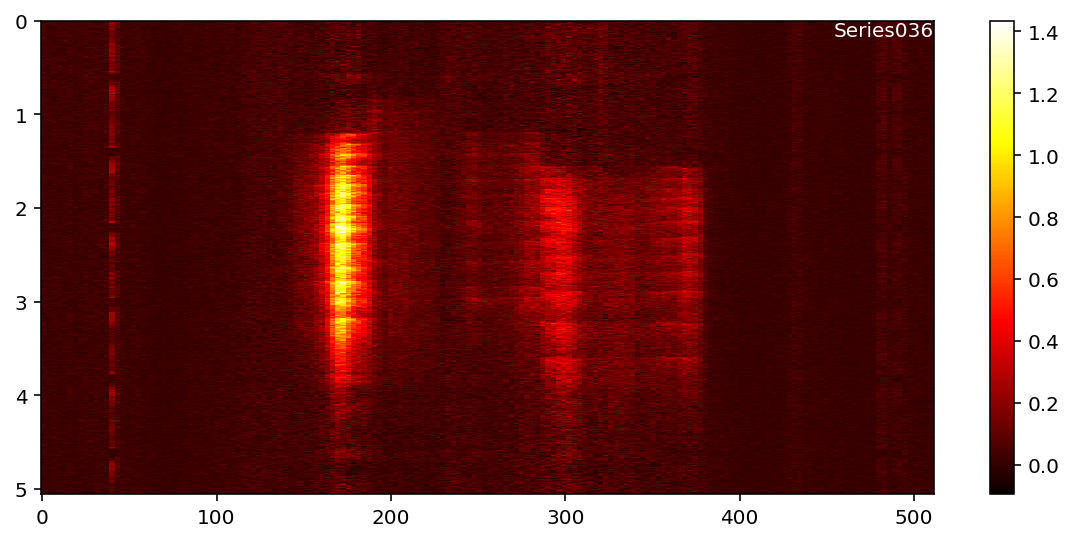

In [316]:
fig, axs = plt.subplots(len(Coll),1,figsize=(10,20))#,dpi =150)
tWin,pxWin = 100,3
interesting = []
for ID,ax in zip(Coll.index, axs):
    t0,LineT,times = Coll.loc[ID,["t0","LineT","times"]]
    im = rebin(rebin(LineT,tWin),pxWin,axis=1)
    offset = np.percentile(im,2,axis=0)
    offsetM = np.array([offset]*len(im))
    X = im-offsetM
#     X = X/X.std()
    t = times+t0
    img = ax.imshow((X),
                    extent=(-.5,LineT.shape[1]-.5,t.max(),t.min()),
#                     vmin=np.percentile(X.flatten(),1),
#                     vmax=2,
                    cmap = "hot"
                   )
    plt.colorbar(img,ax=ax)
    ax.set_aspect("auto")
    ax.text(1,1,ID,transform = ax.transAxes,color="w",ha="right",va="top")
    

#     largeVs = np.percentile(X,99,axis=0)
#     iis = find_peaks(largeVs,prominence=.04)[0]
#     iis = iis[[True]+list(np.diff(iis)>5)]
#     interesting += list(iis)
# interesting = np.unique(interesting)
# for ax in axs:
#     for j in iis:
# #         ax.axvline(j-pxWin-.5,lw=.4,color="lightgrey")
# #         ax.axvline(j+pxWin+.5,lw=.4,color="lightgrey")
#         ax.axvline(j-.5,lw=.3,color="lightgrey")
#         ax.axvline(j+.5,lw=.3,color="lightgrey")
#         ax.text(j/X.shape[1],0,j,color="lightgrey",transform =ax.transAxes)
    break
for ax in axs[1:]:
    ax.remove()

In [313]:
# rb = 1
# largeVs = np.percentile(rebin(X,rb,axis=1),99,axis=0)
# plt.plot(largeVs)
# iis = find_peaks(largeVs,
# #                  width=(.1,3),
#                  prominence=.04,#(.2,1),
# #                  rel_height=10000
#                 )[0]
# iis = iis[list(np.diff(iis)>5)+[True]]
# plt.plot(iis,largeVs[iis],".-")

In [314]:
# fig, axs = plt.subplots(len(Coll),1,figsize=(10,20),dpi =70, sharex=True)
# tWin,pxWin = 100,5
# for ID,ax in zip(Coll.index, axs):
#     t0,LineT,times = Coll.loc[ID,["t0","LineT","times"]]
#     im = rebin(rebin(LineT,tWin),pxWin,axis=1)
#     offset = np.percentile(im,2,axis=0)
#     offsetM = np.array([offset]*len(im))
#     X = im-offsetM
#     X = X/X.std()
#     t = times+t0
#     img = ax.imshow(np.log10(1+X),
#                     extent=(-.5,LineT.shape[1]-.5,t.max(),t.min()),
#                     vmin=np.percentile(X.flatten(),1),
# #                     vmax=2,
#                     cmap = "hot"
#                    )
#     plt.colorbar(img,ax=ax)
#     ax.set_aspect("auto")
#     ax.text(1,1,ID,transform = ax.transAxes,color="w",ha="right",va="top")
#     ax.set_xticks(range(0,X.shape[1],20))
#     ax.set_xticklabels(range(0,X.shape[1],20))
#     for j in iis:
#         ax.axvline(j,lw=.8,color="lightgrey")
# #         ax.axvline(j+.5,lw=.4,color="lightgrey")
# #     break
# # for ax in axs[1:]:
# #     ax.remove()
# fig.tight_layout(w_pad=-.1)
# fig.savefig("/Users/srdjan/Downloads/hot_stacked.png")

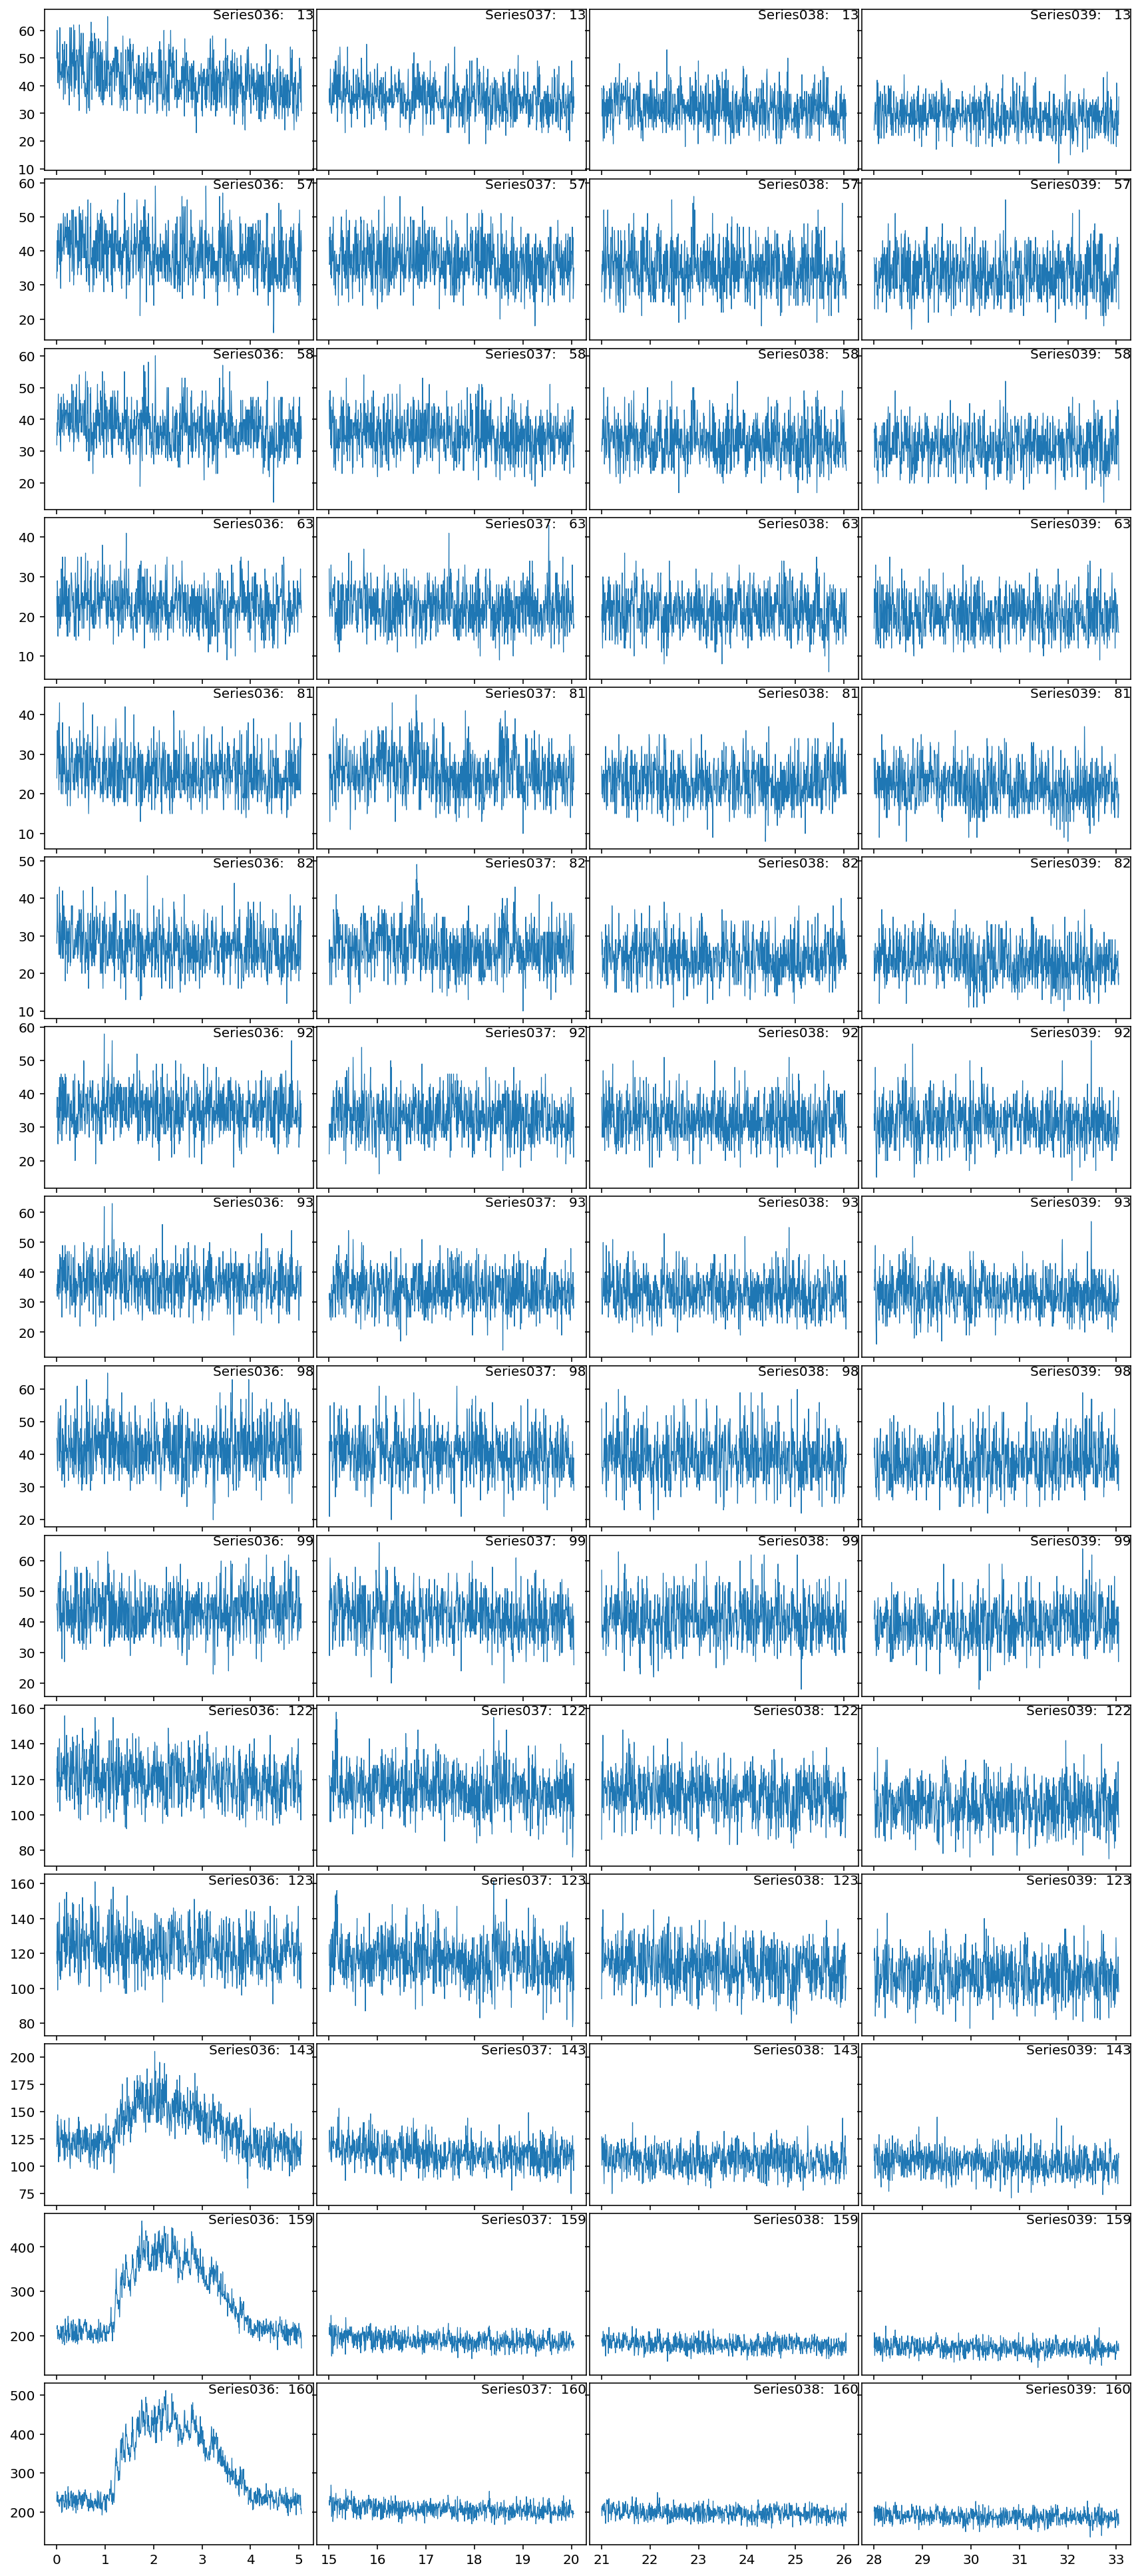

In [315]:
nr = len(interesting)
nc = len(Coll)
fig, axs = plt.subplots(nr,nc,figsize=(3*nc,1.8*nr),sharex="col",sharey="row")
# tWin,pxWin = 400,2
for j,ID in enumerate(Coll.index):
    t0,LineT,times = Coll.loc[ID,["t0","LineT","times"]]
    t = rebin(times+t0,tWin)
    for i,ii in enumerate(interesting):
        im = rebin(LineT[:,ii-pxWin:ii+pxWin+1],tWin,norm=False).sum(axis=1)
        ax = axs[i,j]
        ax.plot(t,im,lw=.6) 
        ax.text(1,1,"%s: %4i"%(ID,ii),transform = ax.transAxes,ha="right",va="top")
#         break
#     break
fig.tight_layout(w_pad=-.1,h_pad=-.1)

In [83]:
Coll

t0                                              times  \
Series036   0  [0.0, 6.316667132907444e-05, 0.000126333342658...   
Series037  15  [0.0, 6.316667132907444e-05, 0.000126333342658...   
Series038  21  [0.0, 6.316667132907444e-05, 0.000126333342658...   
Series039  28  [0.0, 6.315279006958008e-05, 0.000126305580139...   

                                                       LineT frequency  
Series036  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   15831.1  
Series037  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   15831.1  
Series038  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   15831.1  
Series039  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   15834.6

# Other Stuff

In [43]:
# collapse the y-dimension to obtain effectively a line scan
# LineT = np.mean(image,axis=2)

In [53]:
rebinWindows = (1,1,image.shape[-1])

In [54]:
reshapedImage = image.copy()
for j,n in enumerate(rebinWindows):
    reshapedImage = rebin(reshapedImage,n,axis=j)

In [55]:
reshapedImage.shape

(685, 1024, 1)

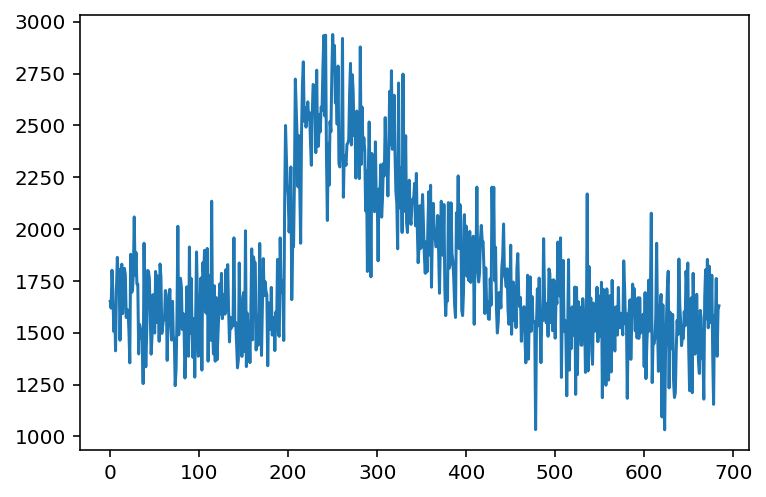

In [60]:
pxShow = (200,0)

plt.plot(reshapedImage[(slice(None),)+pxShow])

In [332]:
smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
offsets = np.percentile(smoothAvgLine,5,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
X = smoothAvgLine - offsetM

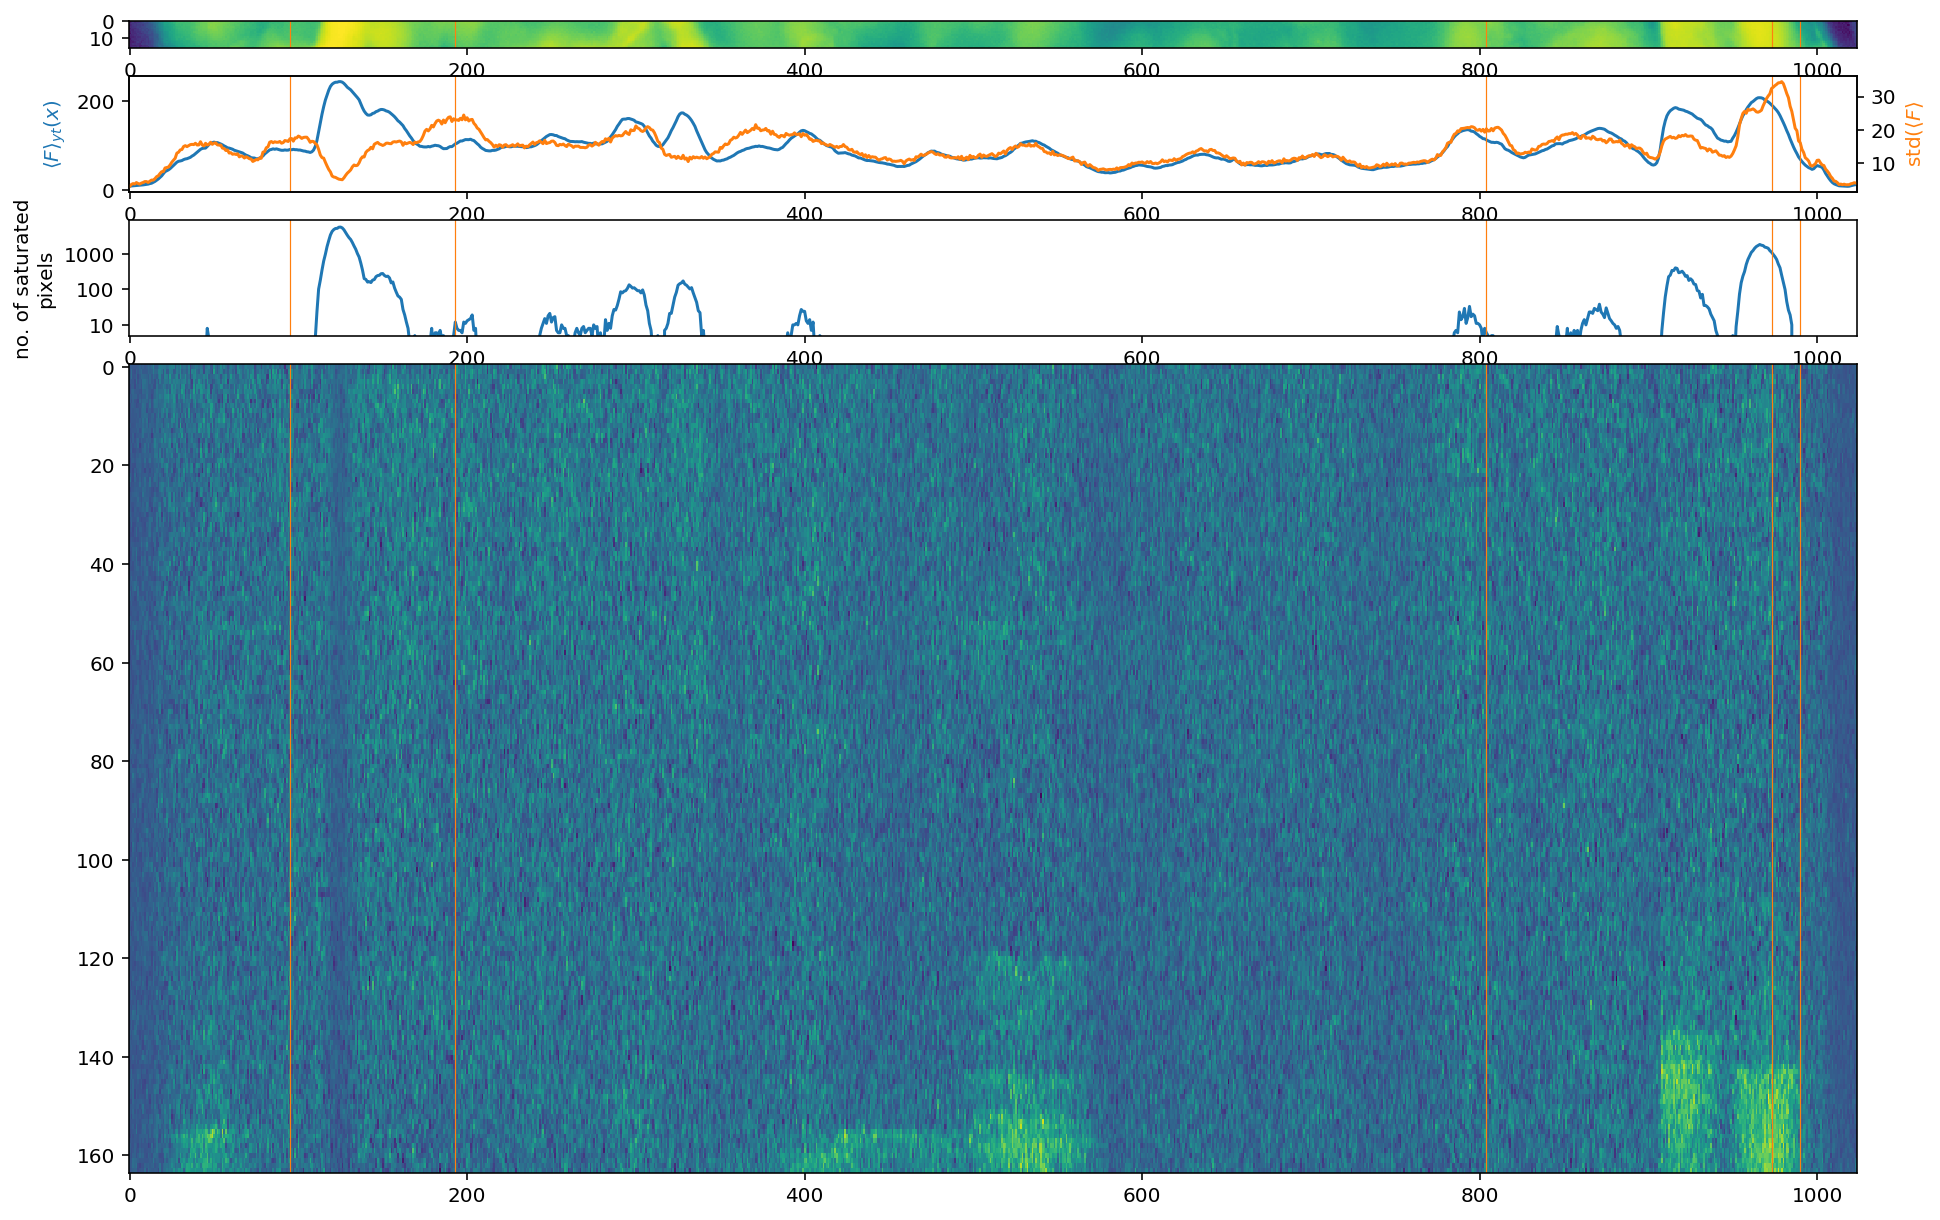

In [366]:
figwidth,figheight = 12,8
ar = dimensions["Y"]/dimensions["X"]*figwidth/figheight
hspacing = [ar,.3/figwidth,1.2/figwidth,.3/figwidth,1.2/figwidth,.3/figwidth]
hspacing += [1-sum(hspacing)]
fig = plt.figure(figsize=(figwidth,figheight))
axs = []
for i in range(0,len(hspacing),2):
    axs += [fig.add_axes([0,1-sum(hspacing[:i+1]),1,hspacing[i]], sharex=axs[-1] if len(axs) else None)]

# axs  = [fig.add_axes([0,(1-ar)*figwidth/figheight,1,ar*figwidth/figheight])]
# axs += [fig.add_axes([0,(1-ar)*(figwidth/figheight+1.5),1,(1-ar)*figwidth/(figheight+.3)],sharex=axs[0])]
# axs += [fig.add_axes([0,0,1,(1-ar)*figwidth/(figheight+.3)],sharex=axs[0])]

ax = axs[0]
ax.imshow(np.log10(1e-1+image.mean(axis=0).T))
ax.set_aspect("equal")

ax = axs[1]
ax.plot(image.mean(axis=(0,2)))
ax.set_ylabel(r"$\langle{F}\rangle{}_{yt}(x)$",color="C0")
axt = ax.twinx()
axt.plot([])
axt.plot(image.mean(axis=2).std(axis=0))
axt.set_ylabel(r"std$(\langle{F}\rangle{}}_{y})_t(x)$",color="C1")


ax = axs[2]
satpx = np.sum(image==image.max(),axis=(0,2))
ax.plot(satpx)
ax.set_ylabel("no. of saturated\npixels")
ax.set_yscale("log")
ax.set_ylim(5,)
ax.set_yticks(10**np.arange(1,int(np.log10(satpx.max()))+1))
ax.set_yticklabels(10**np.arange(1,int(np.log10(satpx.max()))+1))

ax = axs[-1]
ax.imshow(X,
#           extent=(0,X.shape[1],timeWindow[1],timeWindow[0]),
          cmap="viridis")

interesting = [95,193,804,973,990]
for ax in axs:
    for px in interesting:
        ax.axvline(px,lw=.6,color="C1")
# fig.tight_layout(w_pad=.1)
ax.set_aspect("auto")

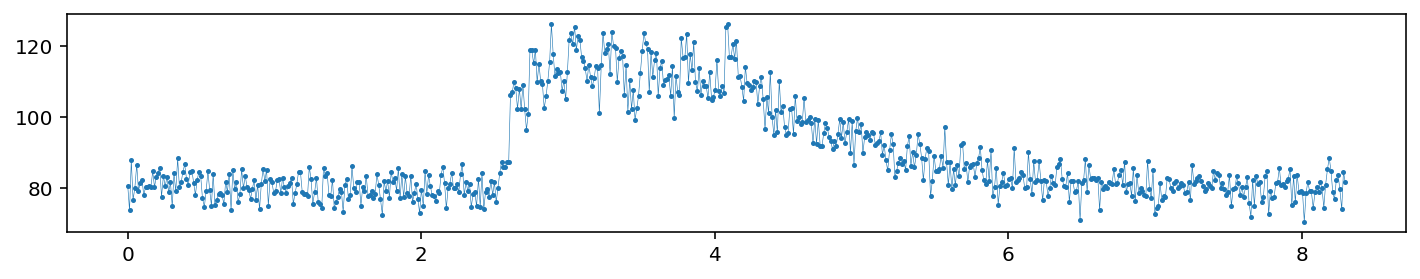

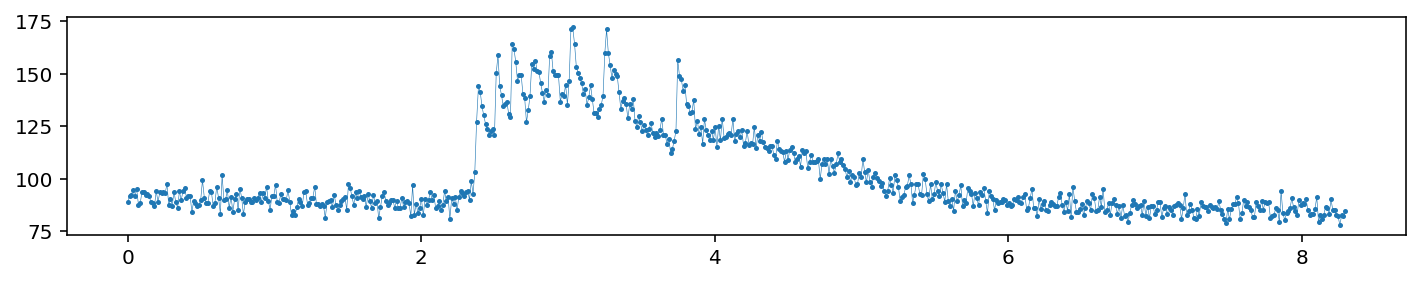

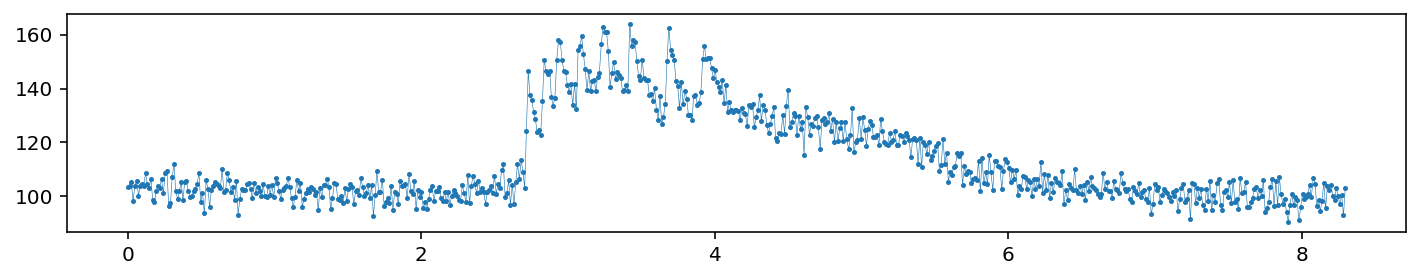

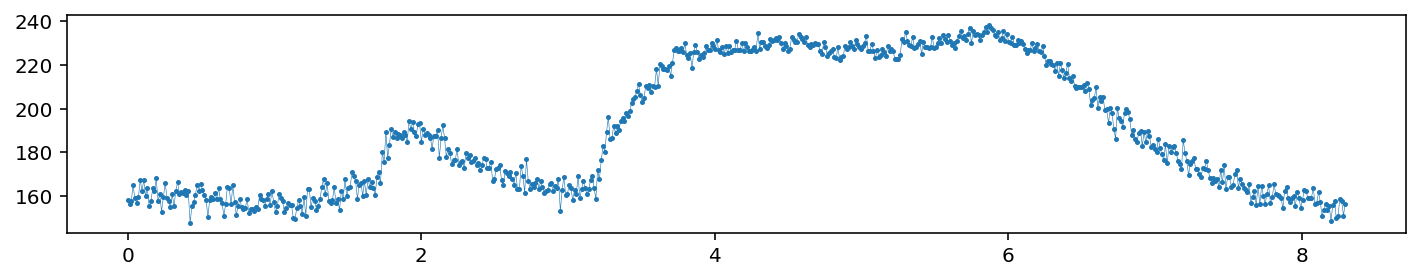

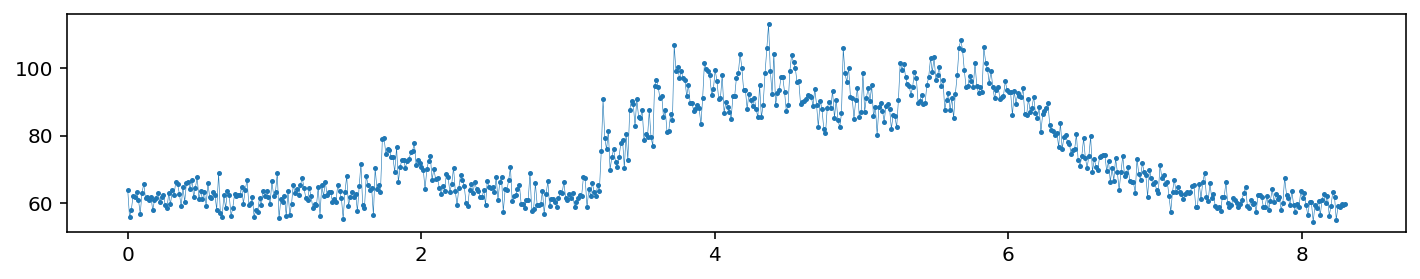

In [266]:
for iShow in interesting[:]:
    plt.figure(figsize=(12,2))
    ax = plt.subplot(111)
#     t,x = times, LineT[:,iShow]
#     ax.plot(t,x,lw=.3)
    t,x = times, LineT[:,iShow-5:iShow+5].mean(axis=1)
    ax.plot(t,x,".-",lw=.3,ms=3)
#     ax.set_xlim(2,4)

## See distributions and filter

In [45]:
Nsample = int(1e7)
pixelSample = np.random.choice(image.flatten(), Nsample)

In [46]:
x,y = np.array(tally(pixelSample)).T
xth =  80
yth = 1e5

<BarContainer object of 53 artists>

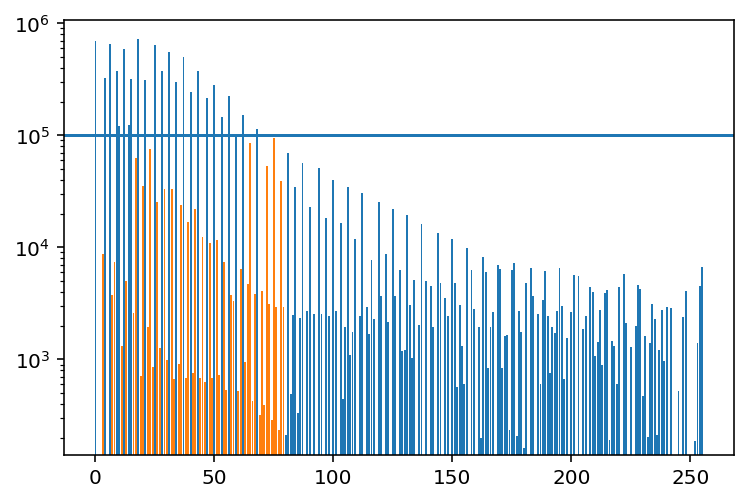

In [47]:
plt.bar(x,y)
plt.yscale("log")
plt.axhline(yth)
take = x[y<yth]
take = take[take<xth]

tmp = pixelSample
tmp = tmp[np.isin(tmp,take)]
x_noise,y_noise = np.array(tally(tmp)).T
plt.bar(x_noise,y_noise)

In [22]:
showTransposed = True

CPU times: user 606 ms, sys: 7.65 ms, total: 614 ms
Wall time: 612 ms


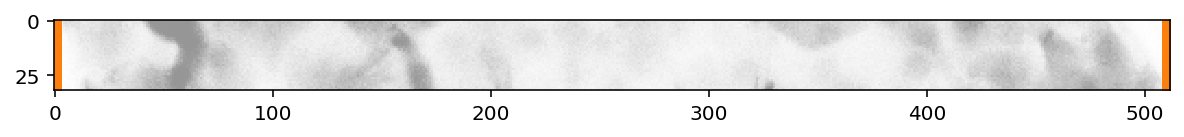

In [23]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims[:],take))):
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [24]:
Nsample = int(1e7)
pixelSampleRed = np.random.choice(image.T[1:-1].flatten(), Nsample)
xRed,yRed = np.array(tally(pixelSampleRed)).T

In [25]:
tmp = xRed[yRed>yth]
tmp = tmp[tmp<xth]
meanDiff = np.diff(tmp).mean()

del tmp

In [26]:
meanDiff

12.666666666666666

In [27]:
collectBulk = [xRed[0]]
for el in xRed[1:-1]:
    if np.abs(el-collectBulk[-1]-meanDiff)<1.5:
        collectBulk += [el]

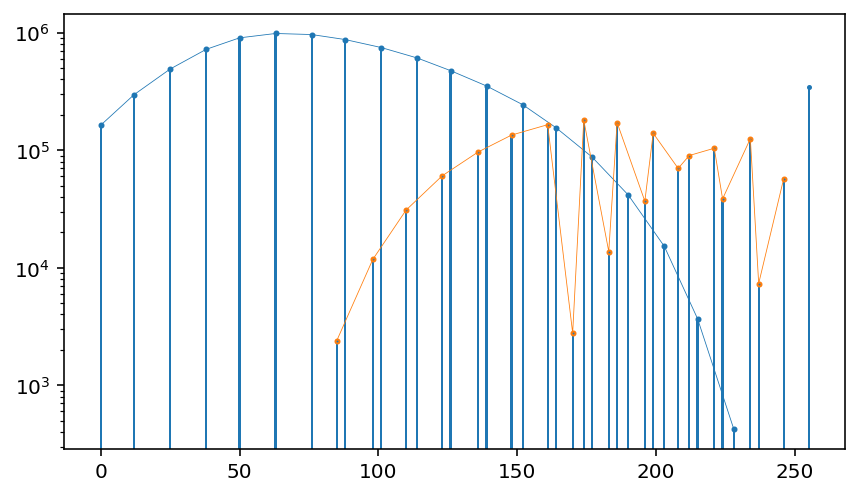

In [28]:
plt.figure(figsize=(7,4))
plt.bar(xRed,yRed,color="C0")
plt.plot(xRed,yRed,".-", ms=3, lw=0,color="C0")
plt.yscale("log")

fltr = np.isin(xRed, collectBulk)
for xf,yf in [
    (xRed[ fltr], yRed[ fltr]),
    (xRed[~fltr], yRed[~fltr]),
]:
    ff = xf!=xRed.max()
    xf = xf[ff]
    yf = yf[ff]
    plt.plot(xf,yf,".-", ms=4, lw=.4, mfc="none")

In [29]:
scale = np.diff(xRed[fltr]).mean()

In [30]:
np.diff(xf)

array([13, 12, 13, 13, 12, 13,  9,  4,  9,  3, 10,  3,  9,  4,  9,  3, 10,
        3,  9])

CPU times: user 807 ms, sys: 14.9 ms, total: 822 ms
Wall time: 820 ms


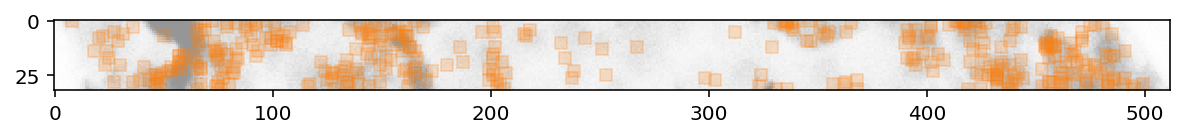

In [31]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in list(zip(*np.where(np.isin(ims[:],xf))))[::100]:
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [32]:
# ## See features

# pd.options.display.max_rows = 100

# tmp = OrderedDict([(k,v) for k,v in constFeatures.items() if
#                                 "Filter" not in k and
#                                 "Channel" not in k and
#                                 "csLutName" not in k
#                                ])
# tmp.update(features.loc[Name])
# tmp = OrderedDict([(k.replace("|"," | "),v) for k,v in tmp.items()])
# tmp = pd.DataFrame(tmp, index=[0]).T
# print (len(tmp))
# tmp

In [33]:
# features[[c for c in features.columns if "nDelayTime" in c]]

# Choose ROI(s) and try analysis

In [34]:
TotalTime = features["DimensionDescription|Length"].loc[Name]

In [35]:
TotalTime

151.905

In [36]:
Frequency = dimensions["T"]/TotalTime

In [37]:
Frequency,Frequency*12

(82.44626642073938, 989.3551970488725)

In [38]:
timeStd = np.std(image, axis=0)

In [39]:
image.shape

(12524, 32, 512)

In [40]:
if Name == "Series051":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
        (np.arange(110,150),
         np.arange( 18, 31)),
        (np.arange(330,370),
         np.arange(  1, 18)),    
        (np.arange(390,410),
         np.arange(  1, 30)),    
        (np.arange(420,450),
         np.arange( 18, 31)),    
    ]
    

if Name == "Series052":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
    ]
    RFs += [
        (np.arange(xx,xx+80),
         np.arange(dimensions["Y"])) for xx in [30,140,270,360]]    

RFs = OrderedDict(zip(range(len(RFs)),RFs))

In [41]:
list(map(lambda xi: len(xi[0]),RFs.values()))

[512, 40, 40, 20, 30]

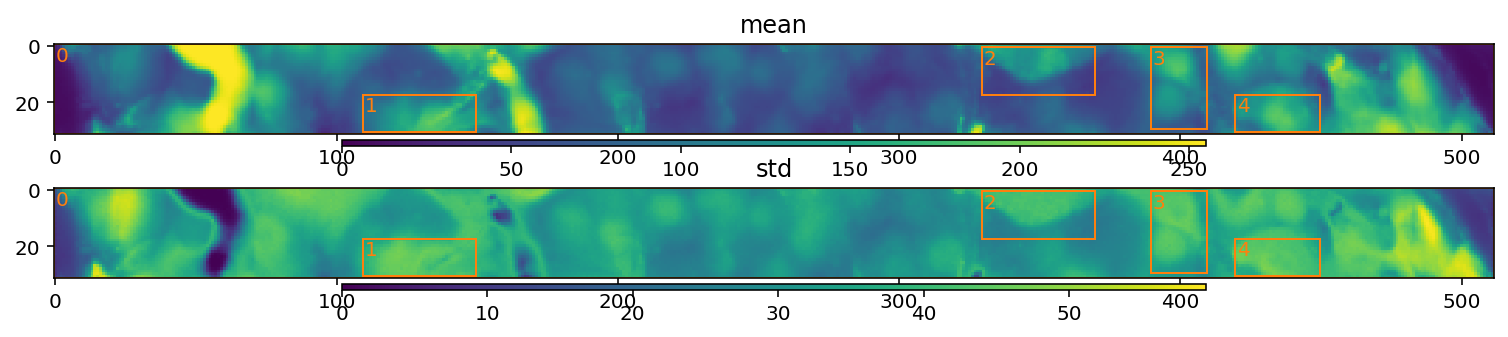

In [42]:
fig = plt.figure(figsize=(10,2))
if showTransposed:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]
else:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]


for X,ax,cax,name in zip([timeStd,np.mean(image,axis=0)],axs,caxs,["std","mean"]):
    if not showTransposed:X = X.T
    im_ = ax.imshow(X, vmin=0)
    plt.colorbar(im_, cax=cax,orientation="horizontal")
    ax.set_title(name)
    ir = 0
    for rfname in RFs:
        regionFilter = RFs[rfname]
        roi = Rectangle(
            (regionFilter[0].min()-.5,regionFilter[1].min()-.5),
            width=len(regionFilter[0]),
            height=len(regionFilter[1]),
            fill=False,
            edgecolor="C1"
        )
        ax.add_patch(roi)
        ax.text(regionFilter[0].min(),regionFilter[1].min(),rfname,color="C1",va="top")
        ir+=1


In [43]:
time = np.linspace(0,TotalTime,dimensions["T"])

In [44]:
AllProfiles = OrderedDict()

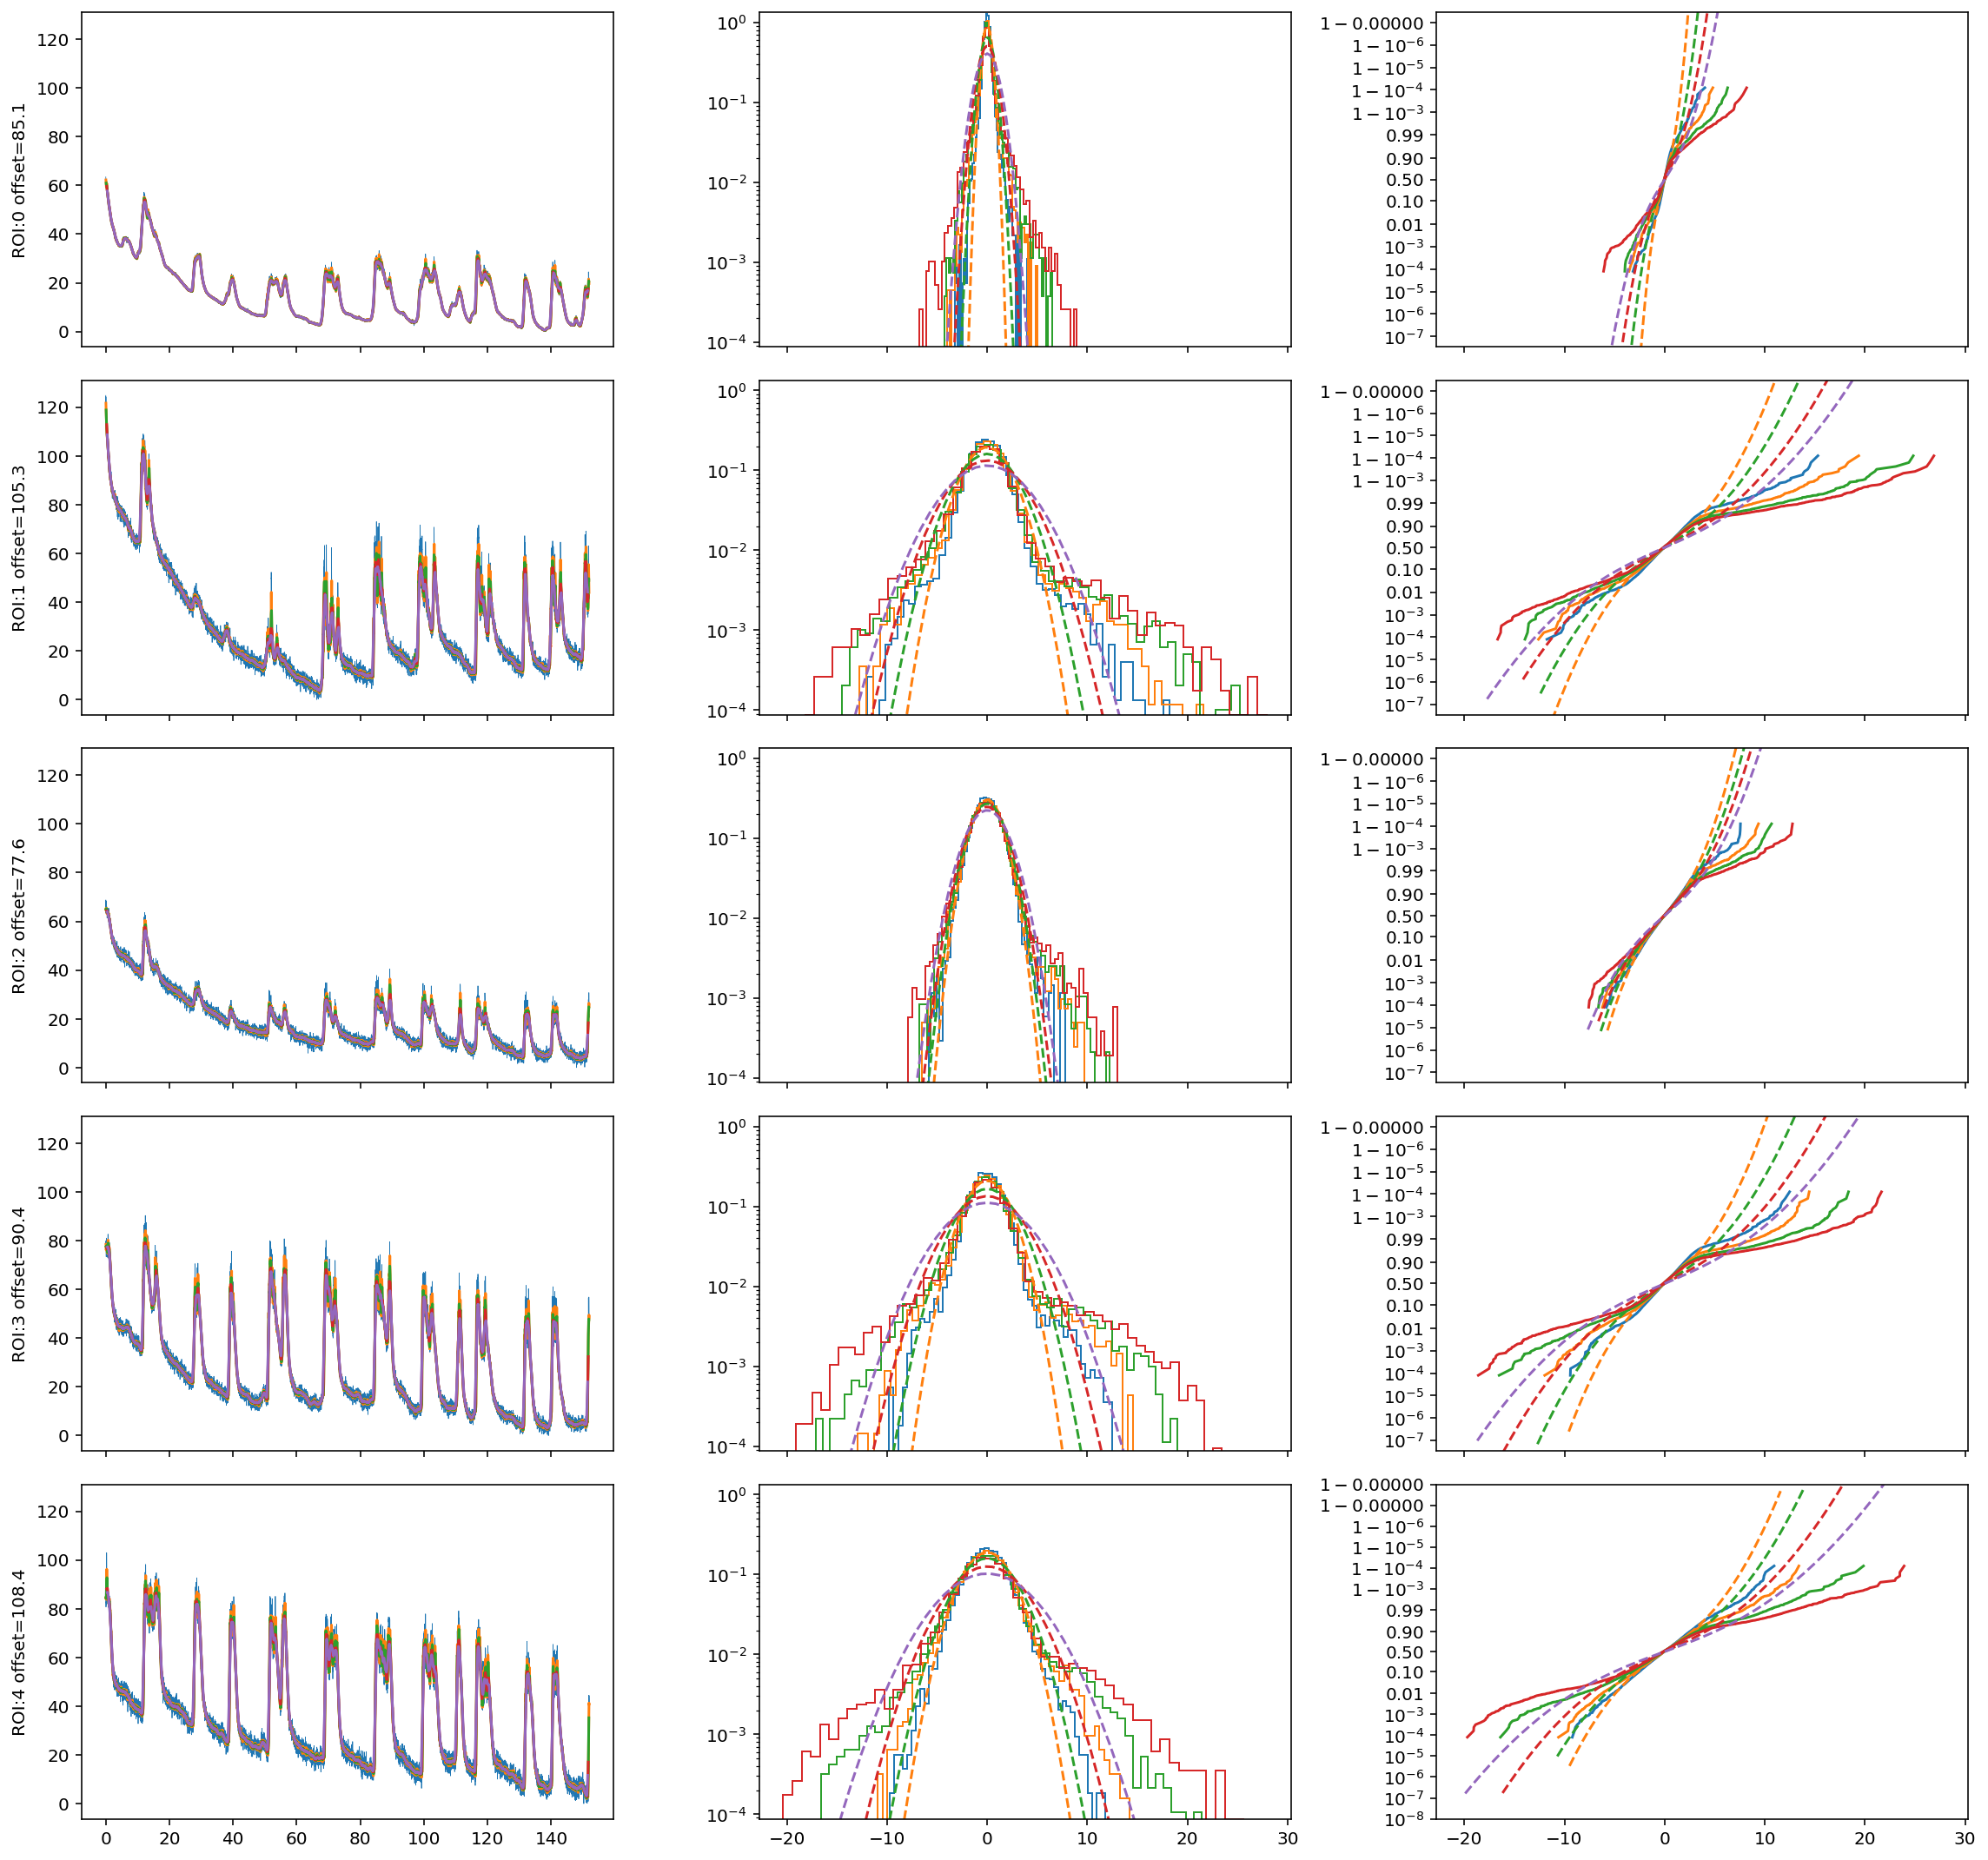

In [45]:
# showRFs = {0:RFs[0]}
showRFs = RFs
fig, Axs = plt.subplots(len(showRFs),3,figsize=(16,3*len(showRFs)), sharex="col", sharey="col")
if len(Axs.shape)==1:
    Axs=Axs.reshape(1,-1)

for ir,rfname in enumerate(showRFs):
    regionFilter = RFs[rfname]
    axs = Axs[ir]
    timeProfile = np.mean(image.T[np.ix_(*regionFilter)].T, axis=(1,2))
    offset = timeProfile.min()
    axs[0].plot(time,timeProfile-offset,lw=.4)
    profileAverages = OrderedDict([("raw",timeProfile)])
    for dtAvg in [10,20,50,80]:
        dtAvg -= 1
        timeProfileAvg = moving_average(timeProfile,dtAvg)
        timeAvg = moving_average(time, dtAvg)
        rest = timeProfile[dtAvg//2:-(dtAvg//2)]-timeProfileAvg
        profileAverages[dtAvg+1] = pd.DataFrame(OrderedDict([
            ("time", timeAvg),
            ("smooth", timeProfileAvg),
            ("rest", rest),
        ]))
        c = axs[0].plot(timeAvg,timeProfileAvg-offset,
#                         label="offset=%.1f"%timeProfileAvg.mean()
                       )[0].get_color()
        yb,bbs,_ = axs[1].hist(rest,50,histtype="step",density=True)
        xb = (bbs[:-1]+bbs[1:])/2
        restStd = rest.std()
        axs[1].plot(xb,dst.norm.pdf(xb,scale=restStd),c=c,ls="--")
        x = rest.copy()
        axs[1].set_ylim(yb[yb>0].min(),)
        axs[2].plot(sorted(x),np.linspace(0,1,len(x)))
        axs[2].plot(xb,dst.norm.cdf(xb,scale=restStd),c=c,ls="--")
#     axs[0].legend()
    axs[0].set_ylabel("ROI:%s offset=%.1f"%(repr(rfname),offset))
    axs[1].set_yscale("log")
    axs[2].set_yscale("logit")
    axs[2].set_yticks(axs[2].get_yticks())
    yx = axs[2].yaxis
    l = yx.get_minor_locator()
    l.minor = False
#     break
    AllProfiles[rfname] = profileAverages
fig.tight_layout()

<IPython.core.display.Javascript object>


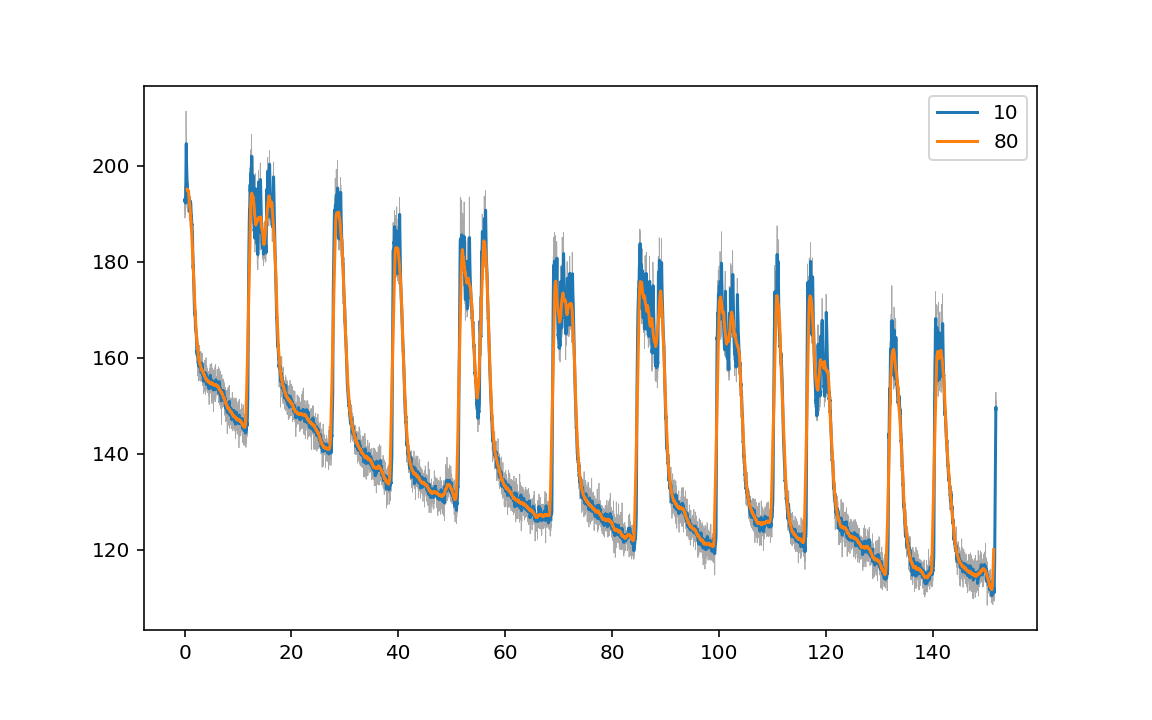

In [47]:
from importlib import reload
reload(plt)
%matplotlib notebook

rfname = 4

plt.figure(figsize=(8,5))

tmp = AllProfiles[rfname]
# for dtAvg in tmp:
for dtAvg in ["raw",10,80]:
    if dtAvg=="raw":
        plt.plot(time,tmp["raw"],color="darkgrey",lw=.4)
    else:
        t,x = tmp[dtAvg][["time","smooth"]].values.T
        plt.plot(t,x,label=dtAvg)
plt.legend()

In [144]:
filename, Name

('Experiment.lif', 'Series052')

## FFT

In [48]:
%matplotlib inline

In [71]:
TotalTime = 20.331 # from Sandra's screenshot

In [118]:
trace1 = tmp["raw"]
trace1 -= trace1.mean()
dt  = TotalTime/len(trace1)
FTs = np.fft.fft(trace1)
N   = len(trace1)
freqs = np.fft.fftfreq(N,dt)
FAs = np.abs(FTs)


In [119]:
PowerSpectrum = FAs**2/(1/dt)**2
print (np.sum(PowerSpectrum)*freqs[1])
print (np.sum(trace1**2)*dt)

71433.8045357824
71433.80453578239


In [120]:
def filterF(x,th=1,h=1):
    return 1/(th**2+x**2)**h

In [121]:

Nshow = N//2
l1 = plt.plot(freqs[:Nshow],PowerSpectrum[:Nshow], label='raw',
              color="darkgreen")
# smooth = 3
# l2 = plt.plot(freqs[smooth//2:Nshow-smooth//2],
#          moving_average(PowerSpectrum[:Nshow], smooth),
#               label='smoothed scale=%i'%smooth, color="indigo")

plt.ylabel('power spectrum')
plt.xlabel('frequency (Hz)')
# plt.xlim(2*freqs[1],10.**3.9)
plt.yscale('log')
plt.xscale('log')
plt.twinx()
# plt.xlim(2*freqs[1],10.**3.9)

xr = np.logspace(-2,2.1, 201)

l3 = plt.plot(xr,filterF(xr), label="filter", color="red", ls="--",lw=2)
plt.ylabel('single pole filter')

# lns = l1+l2+l3
# labs = [l.get_label() for l in lns]
# plt.legend(lns, labs, loc=3)
plt.legend()

In [100]:
from importlib import reload
reload(plt)

<IPython.core.display.Javascript object>


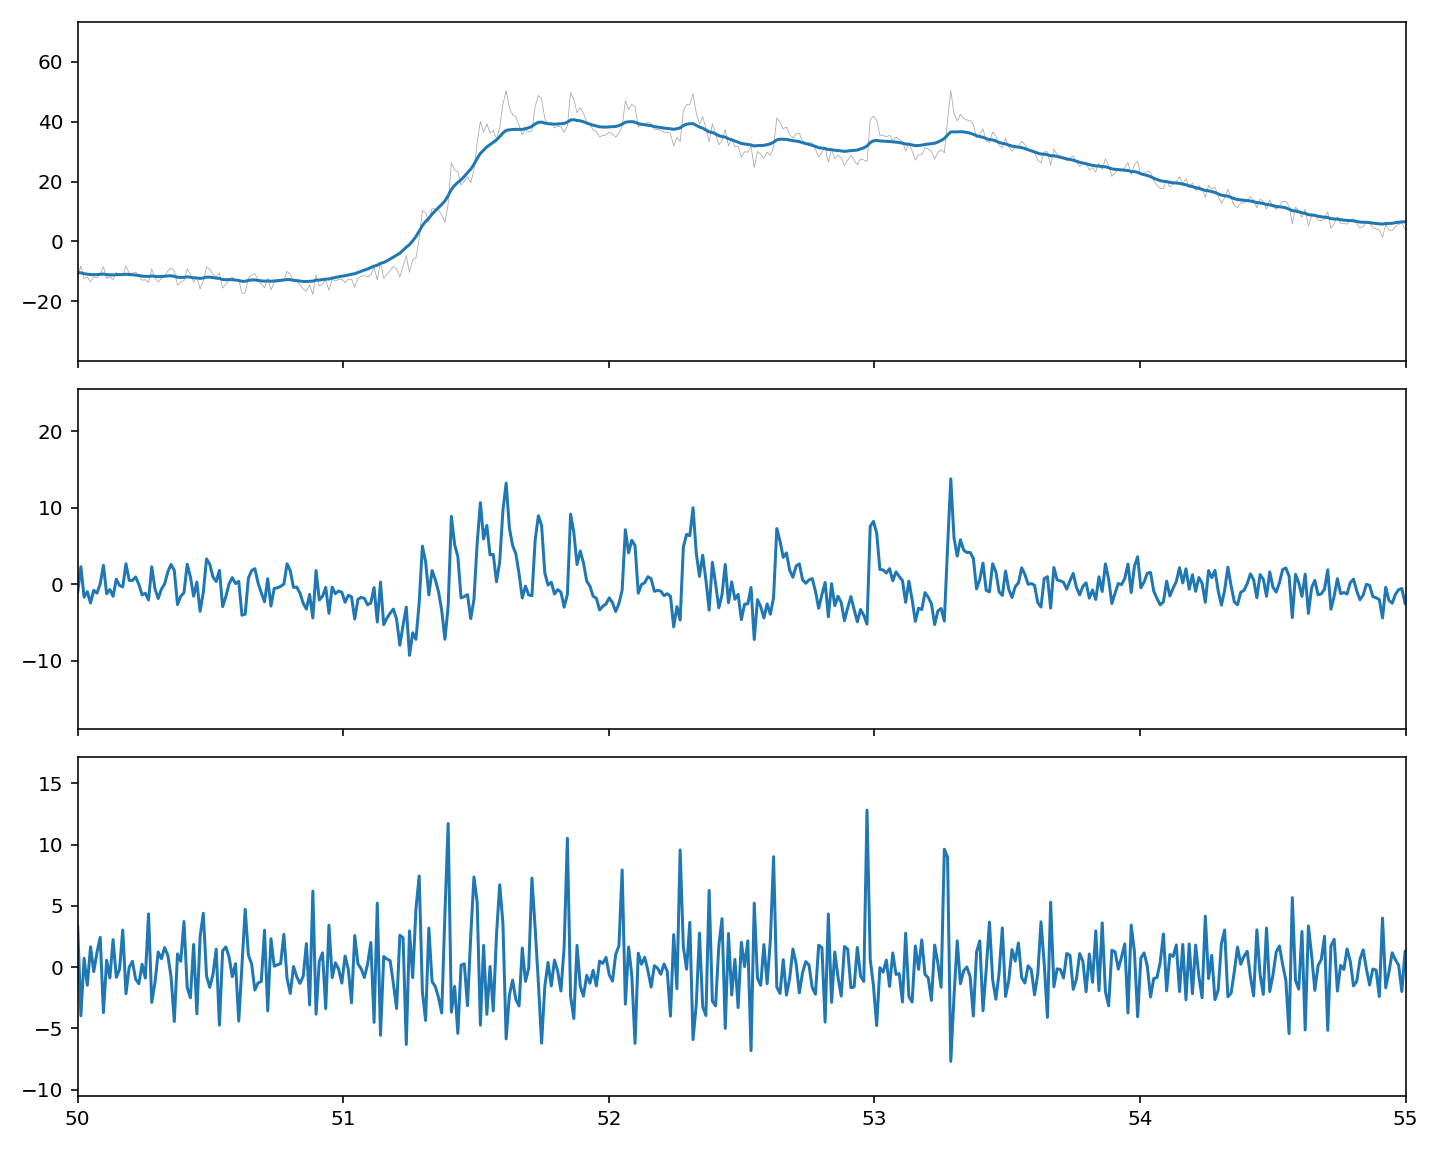

In [145]:
%matplotlib notebook
fig, axs = plt.subplots(3,1,figsize=(10,8), sharex=True)
axs[0].plot(time,trace1,color="darkgrey",lw=.4)

for th in [1]:
    filteredFT = FTs*filterF(freqs,th=th)**.5
    filteredTrace = np.real_if_close(np.fft.ifft(filteredFT))
    axs[0].plot(time,filteredTrace)
    axs[1].plot(time,trace1-filteredTrace)
#     axs[2].plot(time[:-1],np.diff(trace1))
    axs[2].plot(time[:-1],np.diff(trace1-filteredTrace))

axs[1].set_xlim(50,55)
fig.tight_layout()

<IPython.core.display.Javascript object>


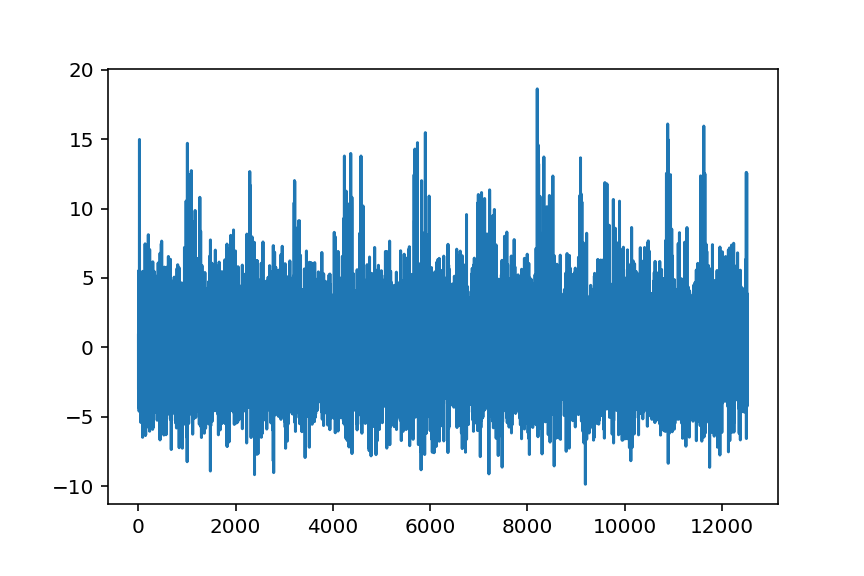

In [141]:
%matplotlib notebook
plt.plot(np.diff(trace1))

# Kill javabridge

In [ ]:
javabridge.kill_vm()